# Jupyter Notebook Interface for CASA

This notebook demonstrates a Jupyter notebook interface to [CASA](https://casa.nrao.edu/), the Common Astronomy Software Applications package developed by NRAO, used for reduction of radio astronomy data such as that of the [VLA](https://science.nrao.edu/facilities/vla) and [ALMA](http://almascience.org/). A standalone version of CASA can be obtained from [here](http://casa.nrao.edu/casa_obtaining.shtml).

This notebook runs in a sandbox on a webserver at ASTRON. There is some demonstration data available in this sandbox. The purpose of this notebook is to introduce the notebook interface. To actually work with the notebook interface, you can install it on your own computer through the instructions at https://github.com/aardk/jupyter-casa.

<img src="https://www.asterics2020.eu/dokuwiki/lib/exe/fetch.php?media=wiki:logo.png" width=100 alt="ASTERICS logo" align="left"> <img src="https://webgate.ec.europa.eu/fpfis/cms/farnet/files/images/Logo_EU_right.png" width=80 alt="EU emblem" align="right">
The notebook interface to CASA was developed by Aard Keimpema at the [Joint Institute for VLBI ERIC (JIVE)](https://jive.eu). Installation in the sandbox interface (based on [tmpnb](https://github.com/jupyter/tmpnb)) was done by Tammo Jan Dijkema at [ASTRON](http://www.astron.nl). This work is a part of the [ASTERICS](http://www.asterics2020.eu) project, Astronomy ESFRI & Research Infrastructure Cluster ASTERICS - 653477. 

This notebook interface was built on top of CASA 5.1.1. Adaptions were made to run it on a newer version of Python than the one distributed with CASA. Future development of this notebook, or upgrading the underlying CASA version, is currently being planned.

In [1]:
casa['build']['version']

'5.1.1-5  '

The current notebook is taken from the [VLA Continuum Tutorial](https://casaguides.nrao.edu/index.php?title=VLA_Continuum_Tutorial_3C391). The dataset inside this sandbox has been averaged down considerably in size, the original was 3GB data, so the results will be worse than in the tutorial.

**NB: This container is for demonstration purposes only, it will be deleted automatically after 5 minutes of inactivity**

### Tutorial, inspect the data

To get a sense of the array, as well as identify an antenna for later use in calibration, we use the task **`plotants`**.

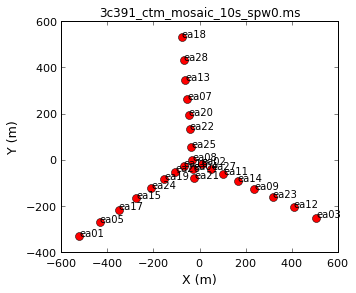

Show log 2018-03-05 11:10:27	INFO	plotants::::	Preparing data ... 
 2018-03-05 11:10:28	INFO	plotants::::	Now get the data
 2018-03-05 11:10:28	INFO	plotants::::	Done Processing data ... 
 2018-03-05 11:10:28	INFO	plotants::::	Saving plot to file plotants_3c391_antenna_layout.png
 2018-03-05 11:10:28	INFO	plotants::::	msplot clear cache: 
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/WEATHER
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/STATE
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/SPECTRAL_WINDOW
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/SOURCE
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/PROCESSOR
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/POLARIZATION
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/POINTING
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/OBSERVATION
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/HISTORY
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/FLAG_CMD
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/FIELD
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/FEED
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/DATA_DESCRIPTION
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms/ANTENNA
 2018-03-05 11:10:28	INFO	plotants::::+	/home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms

In [1]:
plotants(vis='3c391_ctm_mosaic_10s_spw0.ms',
         figfile='plotants_3c391_antenna_layout.png')
clearstat()  # This removes the table lock generated by plotants in script mode

We now inspect some basic information about the data. The task **`listobs`** can be used to get a listing of the individual scans comprising the observation, the frequency setup, source list, and antenna locations. 

In [2]:
listobs(vis='3c391_ctm_mosaic_10s_spw0.ms')

           MeasurementSet Name:  /home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms      MS Version 2
   Observer: Dr. James Miller-Jones     Project: T.B.D.  
Observation: EVLA
Data records: 845379       Total elapsed time = 28681.5 seconds
   Observed from   24-Apr-2010/08:02:10.0   to   24-Apr-2010/16:00:11.5 (UTC)

   ObservationID = 0         ArrayID = 0
  Date        Timerange (UTC)          Scan  FldId FieldName             nRows     SpwIds   Average Interval(s)    ScanIntent
  24-Apr-2010/08:02:10.0 - 08:02:30.0     1      0 J1331+3030                 650  [0]  [10] 
              08:02:20.0 - 08:09:30.0     2      0 J1331+3030               13975  [0]  [10] 
              08:09:20.0 - 08:16:28.0     3      0 J1331+3030               13975  [0]  [10] 
              08:19:38.0 - 08:24:26.5     4      1 J1822-0938                7035  [0]  [10] 
              08:24:48.0 - 08:29:48.0     5      2 3C391 C1                  7590  [0]  [10] 
              08:29:38.0 - 08:34:48.0 

True

Show log 2018-03-05 11:10:35	INFO	listobs::ms::summary	Writing output to file: casapy_temp.txt
 2018-03-05 11:10:35	INFO	listobs::MSMetaData::_computeScanAndSubScanProperties Computing scan and subscan properties...

The log of this task can be shown by clicking the blue button.

## Examining and editing the data

It is always a good idea to examine the data before jumping straight into calibration. Moreover, from the observer's log, we already know that one antenna will need to be flagged because it does not have a C-band receiver. Start by flagging data known to be bad, then examine the data. 

From the listobs output above, one may have noticed that the first scan is less than 1 minute long. This first scan can safely be flagged. This can be done using the task **`flagdata`**.

In [3]:
flagdata(vis='3c391_ctm_mosaic_10s_spw0.ms',
         flagbackup=T, mode='manual', scan='1');

Show log 2018-03-05 11:10:50	INFO	flagdata::::	Backup original flags before applying new flags
 2018-03-05 11:10:50	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:10:50	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called flagdata_1
 2018-03-05 11:10:51	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:10:51	INFO	flagdata::::	Manual mode is active
 2018-03-05 11:10:51	INFO	flagdata::::	Initializing the agents
 2018-03-05 11:10:51	INFO	Manual::setAgentParameters autocorr is 0
 2018-03-05 11:10:51	INFO	AgentFlagger::initAgents	There are 1 valid agents in list
 2018-03-05 11:10:51	INFO	flagdata::::	Running the agentflagger tool
 2018-03-05 11:10:51	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:10:51	INFO	FlagMSHandler::	Chunk = 1 [progress: 100%], Observation = 0, Array = 0, Scan = 1, Field = 0 (J1331+3030), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 650
 2018-03-05 11:10:51	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:10:51	INFO	FlagMSHandler::nextChunk ==================================================================================== 
 2018-03-05 11:10:51	INFO	Manual::tableSummary	=> Percentage of data flagged in table selection: 100%
 2018-03-05 11:10:51	INFO	AgentFlagger::run	=> Writing flags to the MS
 2018-03-05 11:10:51	INFO	flagdata::::	CASA Version 5.1.1-5 
 2018-03-05 11:10:51	INFO	flagdata::::

The logs (visible by clicking the blue button), indicate that, among other things, the flags that existed in the data set prior to this run will be saved to another file called `flagdata_1`. Should you ever desire to revert to the data prior to this run, the task **`flagmanager`** could be used.

 From the observer's log, we know that antenna `ea13` does not have a C-band receiver and antenna `ea15` had some corrupted data, so they should be flagged as well.

In [4]:
flagdata(vis='3c391_ctm_mosaic_10s_spw0.ms',
         flagbackup=T, mode='manual', antenna='ea13,ea15');

Show log 2018-03-05 11:11:00	INFO	flagdata::::	Backup original flags before applying new flags
 2018-03-05 11:11:00	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:11:00	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called flagdata_2
 2018-03-05 11:11:01	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:11:01	INFO	flagdata::::	Manual mode is active
 2018-03-05 11:11:01	INFO	flagdata::::	Initializing the agents
 2018-03-05 11:11:01	INFO	Manual::setAgentParameters autocorr is 0
 2018-03-05 11:11:01	INFO	AgentFlagger::initAgents	There are 1 valid agents in list
 2018-03-05 11:11:01	INFO	flagdata::::	Running the agentflagger tool
 2018-03-05 11:11:01	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:01	INFO	FlagMSHandler::	Chunk = 1 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (J1331+3030), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 98
 2018-03-05 11:11:01	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:11:01	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:01	INFO	FlagMSHandler::	Chunk = 2 [progress: 1%], Observation = 0, Array = 0, Scan = 2, Field = 0 (J1331+3030), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 2107
 2018-03-05 11:11:01	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:11:01	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:01	INFO	FlagMSHandler::	Chunk = 3 [progress: 3%], Observation = 0, Array = 0, Scan = 3, Field = 0 (J1331+3030), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 2107
 2018-03-05 11:11:01	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:11:01	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:01	INFO	FlagMSHandler::	Chunk = 4 [progress: 4%], Observation = 0, Array = 0, Scan = 4, Field = 1 (J1822-0938), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 1196
 2018-03-05 11:11:01	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:11:01	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:01	INFO	FlagMSHandler::	Chunk = 5 [progress: 5%], Observation = 0, Array = 0, Scan = 5, Field = 2 (3C391 C1), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 1290
 2018-03-05 11:11:01	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:11:01	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:01	INFO	FlagMSHandler::	Chunk = 6 [progress: 6%], Observation = 0, Array = 0, Scan = 6, Field = 3 (3C391 C2), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 1331
 2018-03-05 11:11:01	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:11:01	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:01	INFO	FlagMSHandler::	Chunk = 7 [progress: 7%], Observation = 0, Array = 0, Scan = 7, Field = 4 (3C391 C3), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 1331
 2018-03-05 11:11:01	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:11:01	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:01	INFO	FlagMSHandler::	Chunk = 8 [progress: 8%], Observation = 0, Array = 0, Scan = 8, Field = 5 (3C391 C4), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 1331
 2018-03-05 11:11:01	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:11:01	INFO	FlagMSHandler::	----------------------------------------------------------------------------

It is common for the array to require a small amount of time to settle down at the start of a scan. Consequently, it has become standard practice to flag the initial samples from the start of each scan. This is known as 'quack' flagging.

In [5]:
flagdata(vis='3c391_ctm_mosaic_10s_spw0.ms',
         mode='quack', quackinterval=10.0, quackmode='beg');

Show log 2018-03-05 11:11:18	INFO	flagdata::::	Backup original flags before applying new flags
 2018-03-05 11:11:18	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:11:18	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called flagdata_3
 2018-03-05 11:11:19	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:11:19	INFO	flagdata::::	Quack mode is active
 2018-03-05 11:11:19	INFO	flagdata::::	Initializing the agents
 2018-03-05 11:11:19	INFO	Quack::setAgentParameters quackinterval is 10
 2018-03-05 11:11:19	INFO	Quack::setAgentParameters quackmode is beg
 2018-03-05 11:11:19	INFO	Quack::setAgentParameters quackincrement is 0
 2018-03-05 11:11:19	INFO	AgentFlagger::initAgents	There are 1 valid agents in list
 2018-03-05 11:11:19	INFO	flagdata::::	Running the agentflagger tool
 2018-03-05 11:11:20	INFO	FlagMSHandler::preSweep 103 Scans found in MS
 2018-03-05 11:11:20	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:20	INFO	FlagMSHandler::	Chunk = 1 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (J1331+3030), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 650
 2018-03-05 11:11:20	INFO	Quack::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:11:20	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:20	INFO	FlagMSHandler::	Chunk = 2 [progress: 1%], Observation = 0, Array = 0, Scan = 2, Field = 0 (J1331+3030), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 13975
 2018-03-05 11:11:20	INFO	Quack::chunkSummary	=> Data flagged so far 4.65116%
 2018-03-05 11:11:20	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:20	INFO	FlagMSHandler::	Chunk = 3 [progress: 3%], Observation = 0, Array = 0, Scan = 3, Field = 0 (J1331+3030), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 13975
 2018-03-05 11:11:20	INFO	Quack::chunkSummary	=> Data flagged so far 4.65116%
 2018-03-05 11:11:20	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:20	INFO	FlagMSHandler::	Chunk = 4 [progress: 4%], Observation = 0, Array = 0, Scan = 4, Field = 1 (J1822-0938), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 7035
 2018-03-05 11:11:20	INFO	Quack::chunkSummary	=> Data flagged so far 3.21251%
 2018-03-05 11:11:20	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:20	INFO	FlagMSHandler::	Chunk = 5 [progress: 5%], Observation = 0, Array = 0, Scan = 5, Field = 2 (3C391 C1), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 7590
 2018-03-05 11:11:20	INFO	Quack::chunkSummary	=> Data flagged so far 6.66667%
 2018-03-05 11:11:20	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:20	INFO	FlagMSHandler::	Chunk = 6 [progress: 6%], Observation = 0, Array = 0, Scan = 6, Field = 3 (3C391 C2), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 7821
 2018-03-05 11:11:20	INFO	Quack::chunkSummary	=> Data flagged so far 6.18847%
 2018-03-05 11:11:20	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:20	INFO	FlagMSHandler::	Chunk = 7 [progress: 6%], Observation = 0, Array = 0, Scan = 7, Field = 4 (3C391 C3), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 7821
 2018-03-05 11:11:20	INFO	Quack::chunkSummary	=> Data flagged so far 6.18847%
 2018-03-05 11:11:20	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:11:20	INFO	FlagMSHandler::	Chunk = 8 [progress: 7%], Observation = 0, Array = 0, Scan = 8, Field = 5 (3C391 C4), Spw = 0, Channels = 64,

Having now done some basic editing of the data, based in part on a priori information, it is time to look at the data to determine if there are any other obvious problems. One task to examine the data themselves is **`plotms`**:

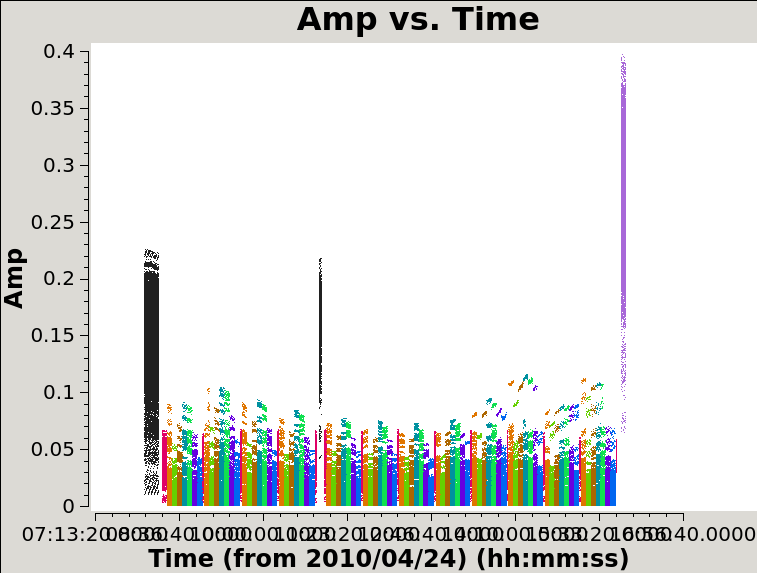

Show log 2018-03-05 11:11:58	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-03-05 11:11:58	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-03-05 11:11:58	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-03-05 11:11:58	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-03-05 11:11:58	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-03-05 11:11:58	INFO	PlotMS::load_cache	START Current memory usage: 3465.23 kilobytes.
 2018-03-05 11:11:58	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-03-05 11:11:58	INFO	PlotMS::load_cache+ Frame = 
 2018-03-05 11:11:58	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-03-05 11:11:58	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-03-05 11:11:58	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-03-05 11:11:58	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-03-05 11:11:58	INFO	PlotMS::load_cache+ formStokes = false
 2018-03-05 11:11:58	INFO	PlotMS::load_cache	Data Averaging: 
 2018-03-05 11:11:58	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-03-05 11:11:58	INFO	PlotMS::load_cache+ Channel: 64 channels
 2018-03-05 11:11:58	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-03-05 11:11:58	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-03-05 11:11:58	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-03-05 11:11:58	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17):data vs. Time(2)...
 2018-03-05 11:11:58	INFO	PlotMS::load_cache	Loading page header cache
 2018-03-05 11:12:02	INFO	PlotMS::load_cache	Data selection will yield a total of 1690758 plottable points (flagged and unflagged).
 2018-03-05 11:12:02	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0204241 GB of memory (12.0799 bytes/point).
 2018-03-05 11:12:02	INFO	PlotMS::load_cache+	This is 0.125069% of the memory avail. to CASA (16.3303 GB).
 2018-03-05 11:12:02	INFO	PlotMS::load_cache	Loading chunks......
 2018-03-05 11:12:17	INFO	PlotMS::load_cache	SPW 0: number of channels averaged = 64
 2018-03-05 11:12:18	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-03-05 11:12:18	INFO	PlotMS::load_cache	refTime = 2010/04/24/00:00:00.0
 2018-03-05 11:12:18	INFO	PlotMS::load_cache	Finished loading.
 2018-03-05 11:12:18	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-03-05 11:12:18	INFO	PlotMS::load_cache	Global ranges:
 2018-03-05 11:12:18	INFO	PlotMS::load_cache+	Time: 4.77881e+09 to 4.77884e+09 (unflagged); ; 4.77881e+09 to 4.77884e+09 (flagged).
 2018-03-05 11:12:18	INFO	PlotMS::load_cache+	Amp:data: 1.09437e-06 to 0.396608 (unflagged); 7.34663e-08 to 0.335867(flagged).
 2018-03-05 11:12:18	INFO	PlotMS::plot	Plotting 1328348 unflagged points.
 2018-03-05 11:11:58	INFO	PlotMS::load_cache	END Time: +19 seconds. Memory: +44584.6 kilobytes.
 2018-03-05 11:12:18	INFO	plotms::::	Plot file /home/keimpema/data2/casa/plotms_temp.png
 2018-03-05 11:12:18	INFO	plotms::::	Exporting the plot.
 2018-03-05 11:12:18	INFO	plotms::::	Calling pm.save
 2018-03-05 11:12:18	INFO	QPExporter::export	START Current memory usage: 48065.3 kilobytes.
 2018-03-05 11:12:18	INFO	QPExporter::export	END Time: +2 seconds. Memory: +53.375 kilobytes.
 2018-03-05 11:12:20	INFO	PlotMS::plot	Exported /home/keimpema/data2/casa/plotms_temp.png

In [6]:
clearstat()  # This removes any existing table locks generated by flagdata
plotms(vis='3c391_ctm_mosaic_10s_spw0.ms',
       selectdata=True, correlation='RR,LL', averagedata=True, avgchannel='64',
       coloraxis='field');

The task **`plotms`** allows one to select and view the data in many ways. Another useful plot we will make is a datastream plot of the antenna2 in a baseline for the data versus `ea01`. This shows, assuming that `ea01` is in the entire observation, when various antennas drop out.

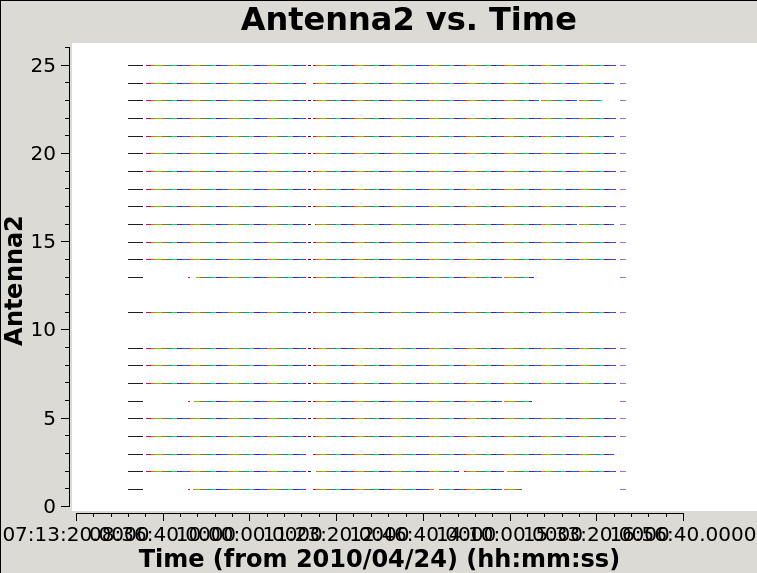

True

Show log 2018-03-05 11:12:22	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-03-05 11:12:22	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-03-05 11:12:22	INFO	PlotMS::load_cache	START Current memory usage: 9344.05 kilobytes.
 2018-03-05 11:12:22	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-03-05 11:12:22	INFO	PlotMS::load_cache+ Frame = 
 2018-03-05 11:12:22	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-03-05 11:12:22	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-03-05 11:12:22	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-03-05 11:12:22	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-03-05 11:12:22	INFO	PlotMS::load_cache+ formStokes = false
 2018-03-05 11:12:22	INFO	PlotMS::load_cache	Data Averaging: None.
 2018-03-05 11:12:22	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-03-05 11:12:22	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-03-05 11:12:22	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-03-05 11:12:22	INFO	PlotMS::load_cache	Caching for the new plot: Antenna2(10) vs. Time(2)...
 2018-03-05 11:12:23	INFO	PlotMS::load_cache	Loading page header cache
 2018-03-05 11:12:25	INFO	PlotMS::load_cache	Data selection will yield a total of 134706 plottable points (flagged and unflagged).
 2018-03-05 11:12:25	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.00121253 GB of memory (9.00129 bytes/point).
 2018-03-05 11:12:25	INFO	PlotMS::load_cache+	This is 0.00742504% of the memory avail. to CASA (16.3303 GB).
 2018-03-05 11:12:26	INFO	PlotMS::load_cache	Loading chunks......
 2018-03-05 11:12:26	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-03-05 11:12:26	INFO	PlotMS::load_cache	refTime = 2010/04/24/00:00:00.0
 2018-03-05 11:12:26	INFO	PlotMS::load_cache	Finished loading.
 2018-03-05 11:12:26	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-03-05 11:12:26	INFO	PlotMS::load_cache	Global ranges:
 2018-03-05 11:12:26	INFO	PlotMS::load_cache+	Time: 4.77881e+09 to 4.77884e+09 (unflagged); ; 4.77881e+09 to 4.77884e+09 (flagged).
 2018-03-05 11:12:26	INFO	PlotMS::load_cache+	Antenna2: 1 to 25 (unflagged); 1 to 25(flagged).
 2018-03-05 11:12:26	INFO	PlotMS::plot	Plotting 57391 unflagged points.
 2018-03-05 11:12:22	INFO	PlotMS::load_cache	END Time: +4 seconds. Memory: +14085 kilobytes.
 2018-03-05 11:12:26	INFO	plotms::::	Plot file /home/keimpema/data2/casa/plotms_temp.png
 2018-03-05 11:12:27	INFO	plotms::::	Exporting the plot.
 2018-03-05 11:12:27	INFO	plotms::::	Calling pm.save
 2018-03-05 11:12:27	INFO	QPExporter::export	START Current memory usage: 23464.7 kilobytes.
 2018-03-05 11:12:27	INFO	QPExporter::export	END Time: +1 seconds. Memory: -53.125 kilobytes.
 2018-03-05 11:12:27	INFO	PlotMS::plot	Exported /home/keimpema/data2/casa/plotms_temp.png

In [7]:
plotms(vis='3c391_ctm_mosaic_10s_spw0.ms', field='', correlation='RR,LL',
       timerange='', antenna='ea01', spw='0:31',
       xaxis='time', yaxis='antenna2',
       plotrange=[-1, -1, 0, 26], coloraxis='field')

From this display, you see immediately that the flagging we did earlier of antennas 10 and 12 (`ea13` and `ea15`) has taken effect. For the remaining antennas, you see that 1, 6, and 13 (`ea02`, `ea08`, and `ea16`) are missing some blocks toward the beginning and also toward the end of the run. Antenna 3 (`ea04`) is missing the last scan (on the polarization calibrator, 3C84) and antenna 23 (`ea26`) is missing scans near the end. None of these antennas should be chosen as the reference calibrator during the calibration process, below. 

## Calibration

It is now time to begin calibrating the data. The general data reduction strategy is to derive a series of scaling factors or corrections from the calibrators, which are then collectively applied to the science data. For more discussion of the philosophy, strategy, and implementation of calibration of synthesis data within CASA, see [Synthesis Calibration](http://casa.nrao.edu/docs/cookbook/casa_cookbook005.html) in the CASA Reference Manual.

Recall that the observed visibility $V^{\prime}$ between two antennas $(i,j)$ is related to the true visibility $V$ by: 

$V^{\prime}_{i,j}(u,v,f) = b_{ij}(t)\,[B_i(f,t) B^{*}_j(f,t)]\,g_i(t) g_j(t)\,V_{i,j}(u,v,f)\,e^{i [\theta_i(t) - \theta_j(t)]}$

Here, for generality, we show the visibility as a function of frequency $f$ and spatial wave numbers $u$ and $v$. The other terms are:

* $g_i$ and $\theta_i$ are the amplitude and phase portions of what is commonly termed the complex gain. They are shown separately here because they are usually determined separately. For completeness, these are shown as a function of time t to indicate that they can change with temperature, atmospheric conditions, etc.
* $B_i$ is the complex bandpass, the instrumental response as a function of frequency $f$. As shown here, the bandpass may also vary as a function of time.
* $b(t)$ is the often-neglected baseline term. It can be important to include for the highest dynamic range images or shortly after a configuration change at the VLA, when antenna positions may not be known well. 

Strictly, the equation above is a simplification of a more general measurement equation formalism, but it is a useful simplification in many cases. 

### A priori Antenna Position Corrections

NRAO monitors the positions of the VLA antennas on a regular basis. The corrections are then placed into an NRAO database. If updated positions were entered into the database *after* your observation date, the corrections to the newly measured positions can still be applied during your data reduction process in this step. Any updated positions that were entered into the database *before* your observations will already be accounted for in your data.

The calculations are inserted via **`gencal`** which allows automated lookup of the corrections. To see how to calculate corrections manually, go to the [VLA Baseline Corrections](http://www.vla.nrao.edu/astro/archive/baselines/) site. 

In [8]:
gencal(vis='3c391_ctm_mosaic_10s_spw0.ms',
       caltable='3c391_ctm_mosaic_10s_spw0.antpos',
       caltype='antpos')

Show log 2018-03-05 11:12:53	INFO	gencal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:12:53	INFO	gencal::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:12:53	INFO	gencal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:12:53	INFO	gencal:::: Determine antenna position offests from the baseline correction database
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea01 : 0.00000 0.00300 0.00000
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea02 : -0.00080 0.00000 0.00000
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea03 : -0.00280 0.00000 0.00000
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea05 : 0.00000 0.00280 0.00000
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea11 : 0.00090 0.00000 0.00000
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea12 : -0.01000 0.00450 -0.00170
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea13 : 0.00000 -0.00080 0.00000
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea17 : -0.00120 0.00000 0.00000
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea18 : 0.00040 -0.00080 0.00040
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea22 : -0.02570 0.00270 -0.01900
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea23 : -0.00140 0.00000 0.00000
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea24 : -0.00150 0.00000 0.00000
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea26 : -0.00190 0.00000 0.00210
 2018-03-05 11:13:00	INFO	gencal::::	offsets for antenna ea27 : 0.00000 0.00190 -0.00160
 2018-03-05 11:13:00	INFO	calibrater::specifycal	Beginning specifycal-----------------------
 2018-03-05 11:13:00	INFO Creating KAntPos Jones table from specified parameters.
 2018-03-05 11:13:00	INFO Writing solutions to table: 3c391_ctm_mosaic_10s_spw0.antpos

In the logger you can see the corrections reported.

### Initial Flux Density Scaling

Let's find the available calibrator models with **`setjy`** and setting the parameter `listmodels=True`:

In [9]:
setjy(vis='3c391_ctm_mosaic_10s_spw0.ms', listmodels=T)


No candidate modimages matching '*.im* *.mod*' found in .

Candidate modimages (*) in /usr/local/casa/data/nrao/VLA/CalModels:
3C138_A.im
3C138_C.im
3C138_K.im
3C138_L.im
3C138_Q.im
3C138_S.im
3C138_U.im
3C138_X.im
3C147_A.im
3C147_C.im
3C147_K.im
3C147_L.im
3C147_Q.im
3C147_S.im
3C147_U.im
3C147_X.im
3C286_A.im
3C286_C.im
3C286_K.im
3C286_L.im
3C286_Q.im
3C286_S.im
3C286_U.im
3C286_X.im
3C48_A.im
3C48_C.im
3C48_K.im
3C48_L.im
3C48_Q.im
3C48_S.im
3C48_U.im
3C48_X.im
README



True

Show log 2018-03-05 11:13:19	INFO	setjy::::	Listing model candidates (listmodels == True).
 2018-03-05 11:13:19	INFO	setjy::::	3c391_ctm_mosaic_10s_spw0.ms is NOT being modified.

Since any image could be a potential calibrator model, setjy will list all `*.im` and `*.mod` images in the working directory. In addition, it will list all models that are provided by NRAO with the CASA package, and they will be picked by their names. We will be using the C-band VLA standard model for 3C286 which is aptly named `'3C286_C.im'`:

In [10]:
setjy(vis='3c391_ctm_mosaic_10s_spw0.ms', field='J1331+3030',
      standard='Perley-Butler 2013', model='3C286_C.im',
      usescratch=False, scalebychan=True, spw='');

Show log 2018-03-05 11:13:46	INFO	setjy::::	{'field': 'J1331+3030'}
 2018-03-05 11:13:46	INFO	Imager::open() Opening MeasurementSet /home/keimpema/data2/casa/3c391_ctm_mosaic_10s_spw0.ms
 2018-03-05 11:13:46	INFO	setjy::::	Using /usr/local/casa/data/nrao/VLA/CalModels/3C286_C.im for modimage.
 2018-03-05 11:13:47	INFO	setjy::::	CASA Version 5.1.1-5 
 2018-03-05 11:13:47	INFO	setjy::::	
 2018-03-05 11:13:50	INFO	imager::setjy()	Using channel dependent flux densities
 2018-03-05 11:13:50	INFO	imager::data selection	Selected 31964 out of 845379 rows.
 2018-03-05 11:13:50	INFO	imager::setjy() J1331+3030 (fld ind 0) spw 0 [I=7.6677, Q=0, U=0, V=0] Jy @ 4.536e+09Hz, (Perley-Butler 2013)
 2018-03-05 11:13:51	INFO	imager::setjy()	Using model image /usr/local/casa/data/nrao/VLA/CalModels/3C286_C.im
 2018-03-05 11:13:51	INFO	imager::setjy()	Scaling spw(s) [0]'s model image by channel to I = 7.66874, 7.59784, 7.53052 Jy @(4.535e+09, 4.601e+09, 4.665e+09)Hz (LSRK) for visibility prediction (a few representative values are shown).
 2018-03-05 11:13:51	INFO	imager::setjy()	The model image's reference pixel is 0.00302169 arcsec from J1331+3030's phase center.
 2018-03-05 11:13:51	INFO	imager::setjy()	Will clear any existing model with matching field=J1331+3030 and spw=*
 2018-03-05 11:13:51	INFO Clearing model records in MS header for selected fields.
 2018-03-05 11:13:51	INFO J1331+3030 (id = 0) not found.
 2018-03-05 11:13:51	INFO	imager::data selection	Selected 31964 out of 845379 rows.

### Initial phase calibration

Before solving for the bandpass, we will do an initial phase calibration. The reason for this step is to average over the (typically small) variations of phase with time in the bandpass, before solving for the bandpass solution itself. Depending upon frequency and configuration, there could be significant gain variations between different scans of the bandpass calibrator, particularly if the scans happen at much different elevations. One can solve for an initial set of antenna-based gains, which will later be discarded, in order to moderate the effects of variations from integration to integration and from scan to scan on the bandpass calibrator. While amplitude variations with time will have little effect on the bandpass solutions, it is important to solve for phase variations with time to prevent de-correlation when vector averaging the data for computing the final bandpass solution.

We use the CASA task **`gaincal`** to solve for phase versus time for the central channels on our three calibrators: 

In [11]:
gaincal(vis='3c391_ctm_mosaic_10s_spw0.ms',
        caltable='3c391_ctm_mosaic_10s_spw0.G0all',
        field='0,1,9', refant='ea21', spw='0:27~36',
        gaintype='G', calmode='p', solint='int',
        minsnr=5, gaintable=['3c391_ctm_mosaic_10s_spw0.antpos'])

Show log 2018-03-05 11:14:30	INFO	gaincal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:14:30	INFO	gaincal::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:14:30	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:14:30	INFO	gaincal::::	NB: gaincal automatically excludes auto-correlations.
 2018-03-05 11:14:30	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-03-05 11:14:30	INFO	calibrater::reset	Reseting solve/apply state
 2018-03-05 11:14:30	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-03-05 11:14:30	INFO	Calibrater::selectvis+ Selecting on spw: '0:27~36'
 2018-03-05 11:14:30	INFO	Calibrater::selectvis+ Selecting on field: '0,1,9'
 2018-03-05 11:14:30	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2018-03-05 11:14:30	INFO	Calibrater::selectvis	By selection 845379 rows are reduced to 80465
 2018-03-05 11:14:30	INFO	Calibrater::selectvis	Frequency selection: 
 2018-03-05 11:14:30	INFO	Calibrater::selectvis	. Spw 0:27~36 (10 channels, step by 1)
 2018-03-05 11:14:30	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2018-03-05 11:14:30	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:14:30	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:14:30	INFO (KAntPos Jones: Overriding with spwmap=[0] since KAntPos Jones is not spw-dependent)
 2018-03-05 11:14:30	INFO (KAntPos Jones: Enforcing calWt()=false for phase/delay-like terms)
 2018-03-05 11:14:30	WARN No VLATrDelCorr keyword in the antpos caltable; turning trop delay correction OFF.
 2018-03-05 11:14:30	INFO	Calibrater::setapply(type, applypar)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:14:30	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-03-05 11:14:30	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2018-03-05 11:14:30	INFO	Calibrater::setsolve	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G0all append=false solint=int refantmode='flex' refant='ea21' minsnr=5 apmode=P solnorm=false
 2018-03-05 11:14:30	INFO	calibrater::solve	Beginning solve-----------------------------
 2018-03-05 11:14:30	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2018-03-05 11:14:30	INFO	Calibrater::solve	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:14:30	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2018-03-05 11:14:30	INFO	Calibrater::solve	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G0all append=false solint=int refantmode='flex' refant='ea21' minsnr=5 apmode=P solnorm=false
 2018-03-05 11:14:30	INFO	ChannelAverageTVI::parseConfiguration	Channel bin is [-1]
 2018-03-05 11:14:30	INFO	Calibrater::solve	For solint = int, found 280 solution intervals.
 2018-03-05 11:14:34	INFO	Calibrater::solve Found good G Jones solutions in 242 solution intervals.
 2018-03-05 11:14:34	INFO Applying refant: ea21 refantmode = flex (hold alternate refants' phase constant) when refant flagged
 2018-03-05 11:14:34	INFO Enforcing apmode on solutions.
 2018-03-05 11:14:36	INFO Writing solutions to table: 3c391_ctm_mosaic_10s_spw0.G0all
 2018-03-05 11:14:38	INFO	calibrater::solve	Finished solving.
 2018-03-05 11:14:38	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2018-03-05 11:14:38	INFO	gaincal:::: Spw 0: 280/242/242

To really see what is going on, we use plotcal to inspect the solutions from **`gaincal`** for a single antenna. Note below, that there are phase jumps for antenna `ea05` where the phase appears to be oscillating between two states.

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


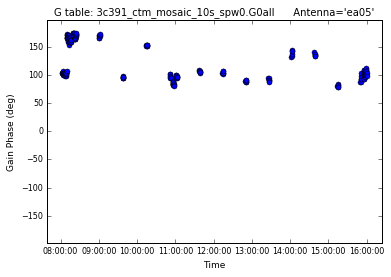

Show log 2018-03-05 11:15:06	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-03-05 11:15:06	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-03-05 11:15:06	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:15:06	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:15:06	INFO	plotcal::FlagVersion::saveFlagVersion	Saving plot to file plotcal_3c391-G0all-phase-R-ea05.png

In [12]:
plotcal(caltable='3c391_ctm_mosaic_10s_spw0.G0all',
        xaxis='time', yaxis='phase', antenna='ea05', poln='R',
        iteration='antenna', plotrange=[-1, -1, -180, 180],
        figfile='plotcal_3c391-G0all-phase-R-ea05.png')

We will not be able to transfer calibration for antenna ea05 so we flag it from the data:

In [13]:
flagdata(vis='3c391_ctm_mosaic_10s_spw0.ms',
         flagbackup=T, mode='manual', antenna='ea05');

Show log 2018-03-05 11:15:16	INFO	flagdata::::	Backup original flags before applying new flags
 2018-03-05 11:15:16	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:15:16	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called flagdata_4
 2018-03-05 11:15:17	INFO	AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:15:17	INFO	flagdata::::	Manual mode is active
 2018-03-05 11:15:17	INFO	flagdata::::	Initializing the agents
 2018-03-05 11:15:17	INFO	Manual::setAgentParameters autocorr is 0
 2018-03-05 11:15:17	INFO	AgentFlagger::initAgents	There are 1 valid agents in list
 2018-03-05 11:15:17	INFO	flagdata::::	Running the agentflagger tool
 2018-03-05 11:15:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:15:17	INFO	FlagMSHandler::	Chunk = 1 [progress: 0%], Observation = 0, Array = 0, Scan = 1, Field = 0 (J1331+3030), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 50
 2018-03-05 11:15:17	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:15:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:15:17	INFO	FlagMSHandler::	Chunk = 2 [progress: 1%], Observation = 0, Array = 0, Scan = 2, Field = 0 (J1331+3030), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 1075
 2018-03-05 11:15:17	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:15:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:15:17	INFO	FlagMSHandler::	Chunk = 3 [progress: 3%], Observation = 0, Array = 0, Scan = 3, Field = 0 (J1331+3030), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 1075
 2018-03-05 11:15:17	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:15:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:15:17	INFO	FlagMSHandler::	Chunk = 4 [progress: 4%], Observation = 0, Array = 0, Scan = 4, Field = 1 (J1822-0938), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 593
 2018-03-05 11:15:17	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:15:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:15:17	INFO	FlagMSHandler::	Chunk = 5 [progress: 5%], Observation = 0, Array = 0, Scan = 5, Field = 2 (3C391 C1), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 660
 2018-03-05 11:15:17	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:15:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:15:17	INFO	FlagMSHandler::	Chunk = 6 [progress: 6%], Observation = 0, Array = 0, Scan = 6, Field = 3 (3C391 C2), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 681
 2018-03-05 11:15:17	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:15:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:15:17	INFO	FlagMSHandler::	Chunk = 7 [progress: 7%], Observation = 0, Array = 0, Scan = 7, Field = 4 (3C391 C3), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 681
 2018-03-05 11:15:17	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:15:17	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2018-03-05 11:15:17	INFO	FlagMSHandler::	Chunk = 8 [progress: 8%], Observation = 0, Array = 0, Scan = 8, Field = 5 (3C391 C4), Spw = 0, Channels = 64, Corrs = [ RR RL LR LL ], Total Rows = 681
 2018-03-05 11:15:17	INFO	Manual::chunkSummary	=> Data flagged so far 100%
 2018-03-05 11:15:17	INFO	FlagMSHandler::	---------------------------------------------------------------------------------

For the following bandpass solution we need only solve for our bandpass calibrator, and we will do so now after flagging. The following call to **`gaincal`** is similar to the one above, but selects only the bandpass calibrator (using the field parameter). This is the calibration table we will use when solving for the bandpass solution, below. 

In [14]:
gaincal(vis='3c391_ctm_mosaic_10s_spw0.ms',
        caltable='3c391_ctm_mosaic_10s_spw0.G0',
        field='J1331+3030', refant='ea21', spw='0:27~36', calmode='p',
        solint='int', minsnr=5, gaintable=['3c391_ctm_mosaic_10s_spw0.antpos'])

Show log 2018-03-05 11:15:41	INFO	gaincal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:15:41	INFO	gaincal::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:15:41	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:15:41	INFO	gaincal::::	NB: gaincal automatically excludes auto-correlations.
 2018-03-05 11:15:41	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-03-05 11:15:41	INFO	calibrater::reset	Reseting solve/apply state
 2018-03-05 11:15:41	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-03-05 11:15:41	INFO	Calibrater::selectvis+ Selecting on spw: '0:27~36'
 2018-03-05 11:15:41	INFO	Calibrater::selectvis+ Selecting on field: 'J1331+3030'
 2018-03-05 11:15:41	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2018-03-05 11:15:41	INFO	Calibrater::selectvis	By selection 845379 rows are reduced to 31964
 2018-03-05 11:15:41	INFO	Calibrater::selectvis	Frequency selection: 
 2018-03-05 11:15:41	INFO	Calibrater::selectvis	. Spw 0:27~36 (10 channels, step by 1)
 2018-03-05 11:15:41	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2018-03-05 11:15:41	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:15:41	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:15:41	INFO (KAntPos Jones: Overriding with spwmap=[0] since KAntPos Jones is not spw-dependent)
 2018-03-05 11:15:41	INFO (KAntPos Jones: Enforcing calWt()=false for phase/delay-like terms)
 2018-03-05 11:15:41	WARN No VLATrDelCorr keyword in the antpos caltable; turning trop delay correction OFF.
 2018-03-05 11:15:41	INFO	Calibrater::setapply(type, applypar)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:15:41	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-03-05 11:15:41	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2018-03-05 11:15:41	INFO	Calibrater::setsolve	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G0 append=false solint=int refantmode='flex' refant='ea21' minsnr=5 apmode=P solnorm=false
 2018-03-05 11:15:41	INFO	calibrater::solve	Beginning solve-----------------------------
 2018-03-05 11:15:41	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2018-03-05 11:15:41	INFO	Calibrater::solve	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:15:41	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2018-03-05 11:15:41	INFO	Calibrater::solve	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G0 append=false solint=int refantmode='flex' refant='ea21' minsnr=5 apmode=P solnorm=false
 2018-03-05 11:15:41	INFO	ChannelAverageTVI::parseConfiguration	Channel bin is [-1]
 2018-03-05 11:15:41	INFO	Calibrater::solve	For solint = int, found 103 solution intervals.
 2018-03-05 11:15:42	INFO	Calibrater::solve Found good G Jones solutions in 95 solution intervals.
 2018-03-05 11:15:42	INFO Applying refant: ea21 refantmode = flex (hold alternate refants' phase constant) when refant flagged
 2018-03-05 11:15:42	INFO Enforcing apmode on solutions.
 2018-03-05 11:15:43	INFO Writing solutions to table: 3c391_ctm_mosaic_10s_spw0.G0
 2018-03-05 11:15:45	INFO	calibrater::solve	Finished solving.
 2018-03-05 11:15:45	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2018-03-05 11:15:45	INFO	gaincal:::: Spw 0: 103/95/95

### Delay calibration

The first stage of bandpass calibration involves solving for the antenna-based delays which put a phase ramp versus frequency channel in each spectral window (Figure 3C). The K gain type in gaincal solves for the relative delays of each antenna relative to the reference antenna (parameter refant), so be sure you pick one that is there for this entire scan and good. This is not a full global delay, but gives one value per spw per polarization.

In [15]:
gaincal(vis='3c391_ctm_mosaic_10s_spw0.ms',
        caltable='3c391_ctm_mosaic_10s_spw0.K0',
        field='J1331+3030', refant='ea21', spw='0:5~58', gaintype='K',
        solint='inf', combine='scan', minsnr=5,
        gaintable=['3c391_ctm_mosaic_10s_spw0.antpos',
                   '3c391_ctm_mosaic_10s_spw0.G0'])

Show log 2018-03-05 11:16:15	INFO	gaincal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:16:15	INFO	gaincal::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:16:15	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:16:15	INFO	gaincal::::	NB: gaincal automatically excludes auto-correlations.
 2018-03-05 11:16:15	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-03-05 11:16:15	INFO	calibrater::reset	Reseting solve/apply state
 2018-03-05 11:16:15	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-03-05 11:16:15	INFO	Calibrater::selectvis+ Selecting on spw: '0:5~58'
 2018-03-05 11:16:15	INFO	Calibrater::selectvis+ Selecting on field: 'J1331+3030'
 2018-03-05 11:16:15	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2018-03-05 11:16:15	INFO	Calibrater::selectvis	By selection 845379 rows are reduced to 31964
 2018-03-05 11:16:15	INFO	Calibrater::selectvis	Frequency selection: 
 2018-03-05 11:16:15	INFO	Calibrater::selectvis	. Spw 0:5~58 (54 channels, step by 1)
 2018-03-05 11:16:15	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2018-03-05 11:16:15	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:16:15	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:16:15	INFO (KAntPos Jones: Overriding with spwmap=[0] since KAntPos Jones is not spw-dependent)
 2018-03-05 11:16:15	INFO (KAntPos Jones: Enforcing calWt()=false for phase/delay-like terms)
 2018-03-05 11:16:15	WARN No VLATrDelCorr keyword in the antpos caltable; turning trop delay correction OFF.
 2018-03-05 11:16:15	INFO	Calibrater::setapply(type, applypar)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:16:15	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:16:15	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:16:15	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G0 select= interp=linear spwmap=[-1] calWt=true
 2018-03-05 11:16:15	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-03-05 11:16:15	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2018-03-05 11:16:15	INFO	Calibrater::setsolve	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 append=false solint=inf refantmode='flex' refant='ea21' minsnr=5 apmode=AP solnorm=false
 2018-03-05 11:16:15	INFO	calibrater::solve	Beginning solve-----------------------------
 2018-03-05 11:16:15	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2018-03-05 11:16:15	INFO	Calibrater::solve	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:16:15	INFO	Calibrater::solve	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G0 select= interp=linear spwmap=[-1] calWt=true
 2018-03-05 11:16:15	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2018-03-05 11:16:15	INFO	Calibrater::solve	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 append=false solint=inf refantmode='flex' refant='ea21' minsnr=5 apmode=AP solnorm=false
 2018-03-05 11:16:15	INFO	Calibrater::solve	For solint = inf, found 1 solution intervals.
 2018-03-05 11:16:17	INFO	Calibrater::solve Found good K Jones solutions in 1 solution intervals.
 2018-03-05 11:16:17	INFO Writing solutions to table: 3c391_ctm_mosaic_10s_spw0.K0
 2018-03-05 11:16:18	INFO	calibrater::solve	Finished solving.
 2018-03-05 11:16:18	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2018-03-05 11:16:18	INFO	gaincal:::: Spw 0: 1/1/1

We can plot these solutions (in nanoseconds) as a function of antenna: 

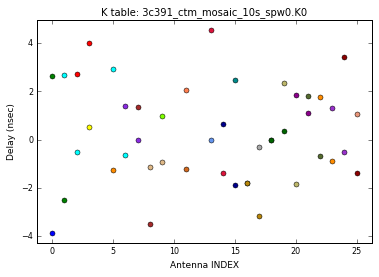

Show log 2018-03-05 11:16:35	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-03-05 11:16:35	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-03-05 11:16:35	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:16:35	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:16:35	INFO	plotcal::FlagVersion::saveFlagVersion	Saving plot to file plotcal_3c391-K0-delay.png

In [16]:
plotcal(caltable='3c391_ctm_mosaic_10s_spw0.K0',
        xaxis='antenna', yaxis='delay',
        figfile='plotcal_3c391-K0-delay.png')

These are within about 4 nanoseconds, as expected for the early science observations with the newly upgraded VLA. 

### Bandpass calibration

This step solves for the complex bandpass, $B_i$. All data with the VLA are taken in spectral line mode, even if the science that one is conducting is continuum, and therefore requires a bandpass solution to account for gain variations with frequency. Solving for the bandpass won't hurt for continuum data, and, for moderate or high dynamic range image, it is essential.

We now form the bandpass, using the phase solutions just derived:

In [17]:
bandpass(vis='3c391_ctm_mosaic_10s_spw0.ms',
         caltable='3c391_ctm_mosaic_10s_spw0.B0',
         field='J1331+3030', spw='', refant='ea21', combine='scan',
         solint='inf', bandtype='B',
         gaintable=['3c391_ctm_mosaic_10s_spw0.antpos',
                    '3c391_ctm_mosaic_10s_spw0.G0',
                    '3c391_ctm_mosaic_10s_spw0.K0'])

Show log 2018-03-05 11:17:03	INFO	bandpass::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:17:03	INFO	bandpass::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:17:03	INFO	bandpass::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:17:03	INFO	bandpass::calibrater::reset	Reseting solve/apply state
 2018-03-05 11:17:03	INFO	bandpass::::	NB: bandpass automatically excludes auto-correlations.
 2018-03-05 11:17:03	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-03-05 11:17:03	INFO	calibrater::reset	Reseting solve/apply state
 2018-03-05 11:17:03	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-03-05 11:17:03	INFO	Calibrater::selectvis+ Selecting on field: 'J1331+3030'
 2018-03-05 11:17:03	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2018-03-05 11:17:03	INFO	Calibrater::selectvis	By selection 845379 rows are reduced to 31964
 2018-03-05 11:17:03	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-03-05 11:17:03	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2018-03-05 11:17:03	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:17:03	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:17:03	INFO (KAntPos Jones: Overriding with spwmap=[0] since KAntPos Jones is not spw-dependent)
 2018-03-05 11:17:03	INFO (KAntPos Jones: Enforcing calWt()=false for phase/delay-like terms)
 2018-03-05 11:17:03	WARN No VLATrDelCorr keyword in the antpos caltable; turning trop delay correction OFF.
 2018-03-05 11:17:03	INFO	Calibrater::setapply(type, applypar)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:17:03	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:17:03	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:17:03	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G0 select= interp=linear spwmap=[-1] calWt=true
 2018-03-05 11:17:03	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:17:03	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:17:03	INFO (K Jones: Enforcing calWt()=false for phase/delay-like terms)
 2018-03-05 11:17:03	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:17:03	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-03-05 11:17:03	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2018-03-05 11:17:03	INFO	Calibrater::setsolve	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 append=false solint=inf,none refantmode='flex' refant='ea21' minsnr=3 apmode=AP solnorm=false
 2018-03-05 11:17:03	INFO	calibrater::solve	Beginning solve-----------------------------
 2018-03-05 11:17:03	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2018-03-05 11:17:03	INFO	Calibrater::solve	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:17:03	INFO	Calibrater::solve	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:17:03	INFO	Calibrater::solve	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G0 select= interp=linear spwmap=[-1] calWt=true
 2018-03-05 11:17:03	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2018-03-05 11:17:03	INFO	Calibrater::solve	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 append=false solint=inf,none refantmode='flex' refant='ea21' minsnr=3 apmode=AP solnorm=false
 2018-03-05 11:17:03	INFO	Calibrater::solve	For solint = inf, found 1 solution intervals.
 201

Once again, one can use plotcal to display the bandpass solutions. Note that in the plotcal inputs below, the amplitudes are being displayed as a function of frequency channel.

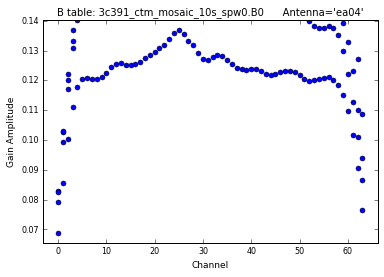

Show log 2018-03-05 11:17:17	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-03-05 11:17:17	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-03-05 11:17:17	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:17:17	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:17:17	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:17:17	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:17:18	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:17:18	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:17:18	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:17:18	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:17:18	INFO	plotcal::FlagVersion::saveFlagVersion	Saving plot to file plotcal_3c391-3C286-B0-R-amp.png

In [18]:
plotcal(caltable='3c391_ctm_mosaic_10s_spw0.B0',
        poln='R', xaxis='chan', yaxis='amp', field='J1331+3030', subplot=221,
        iteration='antenna', figfile='plotcal_3c391-3C286-B0-R-amp.png')

### Gain calibration

The next step is to derive corrections for the complex antenna gains, $g_i$ and $\theta_i$. As discussed above, the absolute magnitude of the gain amplitudes $g_i$ are determined by reference to a standard flux density calibrator.

In principle, one could determine the complex antenna gains for all sources with a single invocation of gaincal; for clarity here, two separate invocations will be used.

In the first step, we derive the appropriate complex gains $g_i$ and $\theta_i$ for the flux density calibrator 3C 286. 

In [19]:
gaincal(vis='3c391_ctm_mosaic_10s_spw0.ms',
        caltable='3c391_ctm_mosaic_10s_spw0.G1',
        field='J1331+3030', spw='0:5~58',
        solint='inf', refant='ea21', gaintype='G', calmode='ap', solnorm=F,
        gaintable=['3c391_ctm_mosaic_10s_spw0.antpos',
                   '3c391_ctm_mosaic_10s_spw0.K0',
                   '3c391_ctm_mosaic_10s_spw0.B0'],
        interp=['linear', 'linear', 'nearest'])

Show log 2018-03-05 11:17:58	INFO	gaincal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:17:58	INFO	gaincal::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:17:58	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:17:58	INFO	gaincal::::	NB: gaincal automatically excludes auto-correlations.
 2018-03-05 11:17:58	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-03-05 11:17:58	INFO	calibrater::reset	Reseting solve/apply state
 2018-03-05 11:17:58	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-03-05 11:17:58	INFO	Calibrater::selectvis+ Selecting on spw: '0:5~58'
 2018-03-05 11:17:58	INFO	Calibrater::selectvis+ Selecting on field: 'J1331+3030'
 2018-03-05 11:17:58	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2018-03-05 11:17:58	INFO	Calibrater::selectvis	By selection 845379 rows are reduced to 31964
 2018-03-05 11:17:58	INFO	Calibrater::selectvis	Frequency selection: 
 2018-03-05 11:17:58	INFO	Calibrater::selectvis	. Spw 0:5~58 (54 channels, step by 1)
 2018-03-05 11:17:58	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2018-03-05 11:17:58	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:17:58	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:17:58	INFO (KAntPos Jones: Overriding with spwmap=[0] since KAntPos Jones is not spw-dependent)
 2018-03-05 11:17:58	INFO (KAntPos Jones: Enforcing calWt()=false for phase/delay-like terms)
 2018-03-05 11:17:58	WARN No VLATrDelCorr keyword in the antpos caltable; turning trop delay correction OFF.
 2018-03-05 11:17:58	INFO	Calibrater::setapply(type, applypar)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:17:58	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:17:58	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:17:58	INFO (K Jones: Enforcing calWt()=false for phase/delay-like terms)
 2018-03-05 11:17:58	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:17:58	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:17:58	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:17:58	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=nearest,linear spwmap=[-1] calWt=true
 2018-03-05 11:17:58	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-03-05 11:17:58	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2018-03-05 11:17:58	INFO	Calibrater::setsolve	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G1 append=false solint=inf refantmode='flex' refant='ea21' minsnr=3 apmode=AP solnorm=false
 2018-03-05 11:17:58	INFO	calibrater::solve	Beginning solve-----------------------------
 2018-03-05 11:17:58	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2018-03-05 11:17:58	INFO	Calibrater::solve	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:17:58	INFO	Calibrater::solve	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=nearest,linear spwmap=[-1] calWt=true
 2018-03-05 11:17:58	INFO	Calibrater::solve	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:17:58	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2018-03-05 11:17:58	INFO	Calibrater::solve	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G1 append=false solint=inf refantmode='flex' refant='ea21' minsnr=3 apmode=AP solnorm=false
 2018-03-05 11:17:58	INFO	ChannelAverageTVI::pa

In the second step, the appropriate complex gains for a direction on the sky close to the target source will be determined from the phase calibrator J1822-0938. We also determine the complex gains for the polarization calibrator source J0319+4130. These will be solved separately, but in practice could be solved together as there are no gaintables that are time dependent at this point (and thus would risk having cross-source interpolation issues), nor are we doing different solution intervals per source.

In [20]:
gaincal(vis='3c391_ctm_mosaic_10s_spw0.ms',
        caltable='3c391_ctm_mosaic_10s_spw0.G1',
        field='J1822-0938', spw='0:5~58',
        solint='inf', refant='ea21', gaintype='G', calmode='ap',
        gaintable=['3c391_ctm_mosaic_10s_spw0.antpos',
                   '3c391_ctm_mosaic_10s_spw0.K0',
                   '3c391_ctm_mosaic_10s_spw0.B0'],
        append=True)

gaincal(vis='3c391_ctm_mosaic_10s_spw0.ms',
        caltable='3c391_ctm_mosaic_10s_spw0.G1',
        field='J0319+4130', spw='0:5~58',
        solint='inf', refant='ea21', gaintype='G', calmode='ap',
        gaintable=['3c391_ctm_mosaic_10s_spw0.antpos',
                   '3c391_ctm_mosaic_10s_spw0.K0',
                   '3c391_ctm_mosaic_10s_spw0.B0'],
        append=True)

Show log 2018-03-05 11:19:16	INFO	gaincal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:19:16	INFO	gaincal::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:19:16	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:19:16	INFO	gaincal::::	NB: gaincal automatically excludes auto-correlations.
 2018-03-05 11:19:16	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-03-05 11:19:16	INFO	calibrater::reset	Reseting solve/apply state
 2018-03-05 11:19:16	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-03-05 11:19:16	INFO	Calibrater::selectvis+ Selecting on spw: '0:5~58'
 2018-03-05 11:19:16	INFO	Calibrater::selectvis+ Selecting on field: 'J1822-0938'
 2018-03-05 11:19:16	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2018-03-05 11:19:16	INFO	Calibrater::selectvis	By selection 845379 rows are reduced to 39733
 2018-03-05 11:19:16	INFO	Calibrater::selectvis	Frequency selection: 
 2018-03-05 11:19:16	INFO	Calibrater::selectvis	. Spw 0:5~58 (54 channels, step by 1)
 2018-03-05 11:19:16	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2018-03-05 11:19:16	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:19:16	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:19:16	INFO (KAntPos Jones: Overriding with spwmap=[0] since KAntPos Jones is not spw-dependent)
 2018-03-05 11:19:16	INFO (KAntPos Jones: Enforcing calWt()=false for phase/delay-like terms)
 2018-03-05 11:19:16	WARN No VLATrDelCorr keyword in the antpos caltable; turning trop delay correction OFF.
 2018-03-05 11:19:16	INFO	Calibrater::setapply(type, applypar)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:19:16	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:19:16	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:19:16	INFO (K Jones: Enforcing calWt()=false for phase/delay-like terms)
 2018-03-05 11:19:16	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:19:16	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:19:16	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:19:16	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=linear,linear spwmap=[-1] calWt=true
 2018-03-05 11:19:16	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2018-03-05 11:19:16	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2018-03-05 11:19:16	INFO	Calibrater::setsolve	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G1 append=true solint=inf refantmode='flex' refant='ea21' minsnr=3 apmode=AP solnorm=false
 2018-03-05 11:19:16	INFO	calibrater::solve	Beginning solve-----------------------------
 2018-03-05 11:19:16	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2018-03-05 11:19:16	INFO	Calibrater::solve	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:19:16	INFO	Calibrater::solve	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=linear,linear spwmap=[-1] calWt=true
 2018-03-05 11:19:16	INFO	Calibrater::solve	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:19:16	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2018-03-05 11:19:16	INFO	Calibrater::solve	. G Jones: table=3c391_ctm_mosaic_10s_spw0.G1 append=true solint=inf refantmode='flex' refant='ea21' minsnr=3 apmode=AP solnorm=false
 2018-03-05 11:19:16	INFO	ChannelAverageTVI::parseC

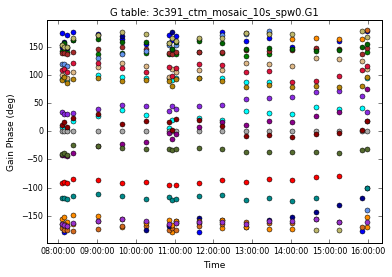

Show log 2018-03-05 11:19:40	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-03-05 11:19:40	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-03-05 11:19:40	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:19:40	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:19:40	INFO	plotcal::FlagVersion::saveFlagVersion	Saving plot to file plotcal_3c391-G1-phase-R.png

In [21]:
plotcal(caltable='3c391_ctm_mosaic_10s_spw0.G1', xaxis='time', yaxis='phase',
        poln='R', plotrange=[-1, -1, -180, 180], figfile='plotcal_3c391-G1-phase-R.png')

If one checks the gain phase solutions using plotcal, one should see smooth solutions for each antenna as a function of time.

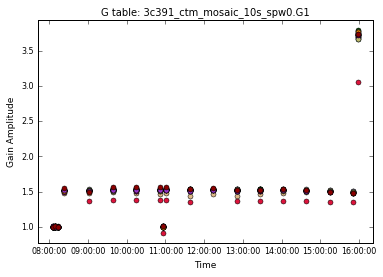

Show log 2018-03-05 11:20:01	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-03-05 11:20:01	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-03-05 11:20:01	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:20:01	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:20:01	INFO	plotcal::FlagVersion::saveFlagVersion	Saving plot to file plotcal_3c391-G1-amp-R.png

In [22]:
plotcal(caltable='3c391_ctm_mosaic_10s_spw0.G1', xaxis='time', yaxis='amp',
        poln='R', figfile='plotcal_3c391-G1-amp-R.png')

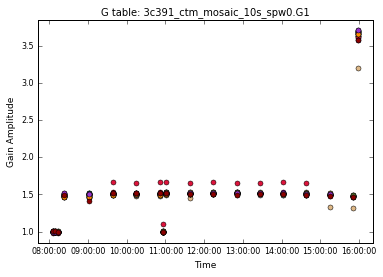

Show log 2018-03-05 11:20:12	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-03-05 11:20:12	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-03-05 11:20:12	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:20:12	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:20:12	INFO	plotcal::FlagVersion::saveFlagVersion	Saving plot to file plotcal_3c391-G1-amp-L.png

In [23]:
plotcal(caltable='3c391_ctm_mosaic_10s_spw0.G1', xaxis='time', yaxis='amp',
        poln='L', figfile='plotcal_3c391-G1-amp-L.png')

This is also a good time to check that our chosen reference antenna (`ea21`) has good phase stability (i.e., the phase difference between the right and left polarizations is stable with time). This is a prerequisite for accurate polarization calibration. To do this, we plot the complex polarization ratio by selecting `poln='/'`: 

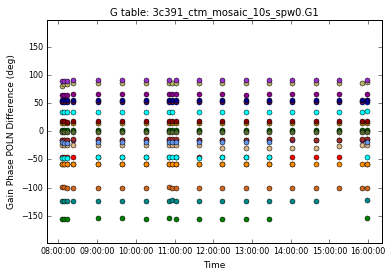

Show log 2018-03-05 11:20:30	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-03-05 11:20:30	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-03-05 11:20:30	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:20:30	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:20:30	INFO	plotcal::FlagVersion::saveFlagVersion	Saving plot to file plotcal_3c391-G1-phase-rat.png

In [24]:
plotcal(caltable='3c391_ctm_mosaic_10s_spw0.G1',
        xaxis='time', yaxis='phase', poln='/', plotrange=[-1, -1, -180, 180],
        figfile='plotcal_3c391-G1-phase-rat.png')

As can be seen above, there is a bit of drift (a few degrees here and there), but no phase jumps. This means that `ea21` is, indeed, a good choice for reference antenna. 

### Scaling the Amplitude Gains

While we know the flux density of our primary calibrator (J1331+3030$\equiv$3C 286), the model assumed for the secondary calibrator (J1822-0938) was a point source of 1 Jy located at the phase center. While the secondary calibrator was chosen to be a point source (at least, over some limited range of uv-distance; see the [VLA calibrator manual](https://science.nrao.edu/facilities/vla/docs/manuals/observing/callist) for any u-v restrictions on your calibrator of choice at the observing frequency), its absolute flux density is unknown. Being point-like, secondary calibrators typically vary on timescales of months to years, in some cases by up to 50-100%. 

We use the primary (flux) calibrator to determine the system response to a source of known flux density and assume that the mean gain amplitudes for the primary calibrator are the same as those for the secondary calibrator. This allows us to find the true flux density of the secondary calibrator. To do this, we use the task **`fluxscale`**, which produces a new calibration table containing properly-scaled amplitude gains for the secondary calibrator. 

In [25]:
myscale = fluxscale(vis='3c391_ctm_mosaic_10s_spw0.ms',
                    caltable='3c391_ctm_mosaic_10s_spw0.G1',
                    fluxtable='3c391_ctm_mosaic_10s_spw0.fluxscale1',
                    reference=['J1331+3030'],
                    transfer=['J1822-0938,J0319+4130'],
                    incremental=False)

Show log 2018-03-05 11:21:05	INFO	fluxscale::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:21:05	INFO	fluxscale::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:21:05	INFO	fluxscale::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:21:05	INFO	fluxscale::calibrater::fluxscale	Beginning fluxscale--(MSSelection version)-------
 2018-03-05 11:21:06	INFO	fluxscale:::: Found reference field(s): J1331+3030
 2018-03-05 11:21:06	INFO	fluxscale:::: Found transfer field(s): J1822-0938 J0319+4130
 2018-03-05 11:21:06	INFO	fluxscale:::: Flux density for J1822-0938 in SpW=0 (freq=4.599e+09 Hz) is: 2.29568 +/- 0.00691973 (SNR = 331.759, N = 46)
 2018-03-05 11:21:06	INFO	fluxscale:::: Flux density for J0319+4130 in SpW=0 (freq=4.599e+09 Hz) is: 13.6662 +/- 0.0388349 (SNR = 351.905, N = 44)
 2018-03-05 11:21:06	INFO	fluxscale::Calibrater::fluxscale	Storing result in 3c391_ctm_mosaic_10s_spw0.fluxscale1
 2018-03-05 11:21:06	INFO	fluxscale::::	Writing solutions to table: 3c391_ctm_mosaic_10s_spw0.fluxscale1
 2018-03-05 11:21:08	INFO	fluxscale::::	CASA Version 5.1.1-5 
 2018-03-05 11:21:08	INFO	fluxscale::::

The task **`fluxscale`** will print to the CASA logger the derived flux densities of all calibrator sources specified with the transfer parameter. These are also captured in the return variable from the task. You should examine the output to ensure that it looks sensible. If the data set has more than one spectral window, depending upon where they are spaced and the spectrum of the source, it is possible to find quite different flux densities and spectral indexes for the secondary calibrators. 

We plot the rescaled amplitudes from this table: 

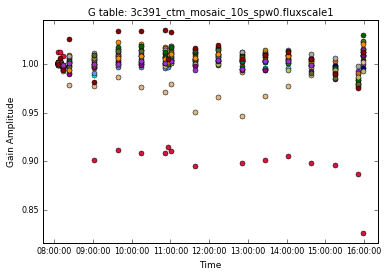

Show log 2018-03-05 11:21:26	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-03-05 11:21:26	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-03-05 11:21:26	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:21:26	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:21:26	INFO	plotcal::FlagVersion::saveFlagVersion	Saving plot to file plotcal_3c391-fluxscale1-amp-R.png

In [26]:
plotcal(caltable='3c391_ctm_mosaic_10s_spw0.fluxscale1',
        xaxis='time', yaxis='amp', poln='R',
        figfile='plotcal_3c391-fluxscale1-amp-R.png')

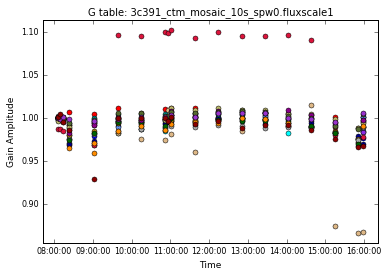

Show log 2018-03-05 11:21:43	INFO	plotcal::tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2018-03-05 11:21:43	INFO	plotcal::plotcal::createCalTab Detected a NewCalTable!
 2018-03-05 11:21:43	INFO	plotcal::FlagVersion::saveFlagVersion	Now get the data
 2018-03-05 11:21:43	INFO	plotcal::FlagVersion::saveFlagVersion	Done Processing data ... 
 2018-03-05 11:21:43	INFO	plotcal::FlagVersion::saveFlagVersion	Saving plot to file plotcal_3c391-fluxscale1-amp-L.png

In [27]:
plotcal(caltable='3c391_ctm_mosaic_10s_spw0.fluxscale1',
        xaxis='time', yaxis='amp', poln='L',
        figfile='plotcal_3c391-fluxscale1-amp-L.png')

You can see in these figures that the amplitude gain factors are now similar across sources, compared to the raw factors in the G1 table. 

## Applying the calibration

Now that we have derived all the calibration solutions, we need to apply them to the actual data, using the task **`applycal`**. The measurement set `DATA` column contains the original data. To apply the calibration we have derived, we specify the appropriate calibration tables, which are then applied to the `DATA` column, with the results being written in the `CORRECTED_DATA` column. If the dataset does not already have a `CORRECTED_DATA` scratch column, then one will be created in the first applycal run. 

First, we apply the calibration to each individual calibrator, using the gain solutions derived on that calibrator alone to compute the CORRECTED_DATA. To do this, we iterate over the different calibrators, in each case specifying the source to be calibrated (using the field parameter).

In [28]:
applycal(vis='3c391_ctm_mosaic_10s_spw0.ms',
         field='J1331+3030',
         gaintable=['3c391_ctm_mosaic_10s_spw0.antpos',
                    '3c391_ctm_mosaic_10s_spw0.fluxscale1',
                    '3c391_ctm_mosaic_10s_spw0.K0',
                    '3c391_ctm_mosaic_10s_spw0.B0'],
         gainfield=['', 'J1331+3030', '', '', '', '', ''],
         interp=['', 'nearest', '', '', '', '', ''],
         calwt=[False],
         parang=True)

Show log 2018-03-05 11:22:15	INFO	applycal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:22:15	INFO	applycal::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:22:15	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:22:15	INFO	applycal::AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:22:15	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called applycal_1
 2018-03-05 11:22:16	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-03-05 11:22:16	INFO	calibrater::reset	Reseting solve/apply state
 2018-03-05 11:22:16	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-03-05 11:22:16	INFO	Calibrater::selectvis+ Selecting on field: 'J1331+3030'
 2018-03-05 11:22:16	INFO	Calibrater::selectvis	By selection 845379 rows are reduced to 31964
 2018-03-05 11:22:16	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-03-05 11:22:16	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-03-05 11:22:16	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:22:16	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:22:16	INFO (KAntPos Jones: Overriding with spwmap=[0] since KAntPos Jones is not spw-dependent)
 2018-03-05 11:22:16	WARN No VLATrDelCorr keyword in the antpos caltable; turning trop delay correction OFF.
 2018-03-05 11:22:16	INFO	Calibrater::setapply(type, applypar)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:22:16	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:22:16	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:22:16	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=3c391_ctm_mosaic_10s_spw0.fluxscale1 select= interp=nearest spwmap=[-1] calWt=false
 2018-03-05 11:22:16	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:22:16	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:22:16	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:22:16	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:22:16	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:22:16	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=linear,linear spwmap=[-1] calWt=false
 2018-03-05 11:22:16	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:22:16	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:22:16	INFO	Calibrater::setapply(type, applypar)	. P Jones 
 2018-03-05 11:22:16	INFO	calibrater::correct	Beginning correct---------------------------
 2018-03-05 11:22:16	INFO	Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2018-03-05 11:22:16	INFO	Calibrater::correct2 (VI2/VB2)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:22:16	INFO	Calibrater::correct2 (VI2/VB2)	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=linear,linear spwmap=[-1] calWt=false
 2018-03-05 11:22:16	INFO	Calibrater::correct2 (VI2/VB2)	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:22:16	INFO	Calibrater::correct2 (VI2/VB2)	. G Jones: table=3c391_ctm_mosaic_10s_spw0.fluxscale1 select= interp=nearest spwmap=[-1] calWt=false
 2018-03-05 11:22:16	INFO	Calibrater::correct2 (VI2/VB2)	. P Jones 
 2018-03-05 11:22:18	INFO	calibrater::correct	Finished correcting.
 2018-03-05 11:22:18	INFO	applycal::::	Calibr

In [29]:
applycal(vis='3c391_ctm_mosaic_10s_spw0.ms',
         field='J0319+4130',
         gaintable=['3c391_ctm_mosaic_10s_spw0.antpos',
                    '3c391_ctm_mosaic_10s_spw0.fluxscale1',
                    '3c391_ctm_mosaic_10s_spw0.K0',
                    '3c391_ctm_mosaic_10s_spw0.B0'],
         gainfield=['', 'J0319+4130', '', '', '', '', ''],
         interp=['', 'nearest', '', '', '', '', ''],
         calwt=[False],
         parang=True)

Show log 2018-03-05 11:22:36	INFO	applycal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:22:36	INFO	applycal::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:22:36	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:22:36	INFO	applycal::AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:22:36	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called applycal_2
 2018-03-05 11:22:38	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-03-05 11:22:38	INFO	calibrater::reset	Reseting solve/apply state
 2018-03-05 11:22:38	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-03-05 11:22:38	INFO	Calibrater::selectvis+ Selecting on field: 'J0319+4130'
 2018-03-05 11:22:38	INFO	Calibrater::selectvis	By selection 845379 rows are reduced to 8768
 2018-03-05 11:22:38	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-03-05 11:22:38	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-03-05 11:22:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:22:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:22:38	INFO (KAntPos Jones: Overriding with spwmap=[0] since KAntPos Jones is not spw-dependent)
 2018-03-05 11:22:38	WARN No VLATrDelCorr keyword in the antpos caltable; turning trop delay correction OFF.
 2018-03-05 11:22:38	INFO	Calibrater::setapply(type, applypar)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:22:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:22:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:22:38	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=3c391_ctm_mosaic_10s_spw0.fluxscale1 select= interp=nearest spwmap=[-1] calWt=false
 2018-03-05 11:22:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:22:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:22:38	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:22:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:22:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:22:38	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=linear,linear spwmap=[-1] calWt=false
 2018-03-05 11:22:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:22:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:22:38	INFO	Calibrater::setapply(type, applypar)	. P Jones 
 2018-03-05 11:22:38	INFO	calibrater::correct	Beginning correct---------------------------
 2018-03-05 11:22:38	INFO	Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2018-03-05 11:22:38	INFO	Calibrater::correct2 (VI2/VB2)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:22:38	INFO	Calibrater::correct2 (VI2/VB2)	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=linear,linear spwmap=[-1] calWt=false
 2018-03-05 11:22:38	INFO	Calibrater::correct2 (VI2/VB2)	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:22:38	INFO	Calibrater::correct2 (VI2/VB2)	. G Jones: table=3c391_ctm_mosaic_10s_spw0.fluxscale1 select= interp=nearest spwmap=[-1] calWt=false
 2018-03-05 11:22:38	INFO	Calibrater::correct2 (VI2/VB2)	. P Jones 
 2018-03-05 11:22:38	INFO	calibrater::correct	Finished correcting.
 2018-03-05 11:22:38	INFO	applycal::::	Calibra

In [30]:
applycal(vis='3c391_ctm_mosaic_10s_spw0.ms',
         field='J1822-0938',
         gaintable=['3c391_ctm_mosaic_10s_spw0.antpos',
                    '3c391_ctm_mosaic_10s_spw0.fluxscale1',
                    '3c391_ctm_mosaic_10s_spw0.K0',
                    '3c391_ctm_mosaic_10s_spw0.B0'],
         gainfield=['', 'J1822-0938', '', '', '', '', ''],
         interp=['', 'nearest', '', '', '', '', ''],
         calwt=[False],
         parang=True)

Show log 2018-03-05 11:23:05	INFO	applycal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:23:05	INFO	applycal::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:23:05	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:23:05	INFO	applycal::AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:23:05	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called applycal_3
 2018-03-05 11:23:06	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-03-05 11:23:06	INFO	calibrater::reset	Reseting solve/apply state
 2018-03-05 11:23:06	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-03-05 11:23:06	INFO	Calibrater::selectvis+ Selecting on field: 'J1822-0938'
 2018-03-05 11:23:06	INFO	Calibrater::selectvis	By selection 845379 rows are reduced to 39733
 2018-03-05 11:23:06	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-03-05 11:23:06	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-03-05 11:23:06	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:23:06	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:23:06	INFO (KAntPos Jones: Overriding with spwmap=[0] since KAntPos Jones is not spw-dependent)
 2018-03-05 11:23:06	WARN No VLATrDelCorr keyword in the antpos caltable; turning trop delay correction OFF.
 2018-03-05 11:23:06	INFO	Calibrater::setapply(type, applypar)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:23:06	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:23:06	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:23:06	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=3c391_ctm_mosaic_10s_spw0.fluxscale1 select= interp=nearest spwmap=[-1] calWt=false
 2018-03-05 11:23:06	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:23:06	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:23:06	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:23:06	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:23:06	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:23:06	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=linear,linear spwmap=[-1] calWt=false
 2018-03-05 11:23:06	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:23:06	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:23:06	INFO	Calibrater::setapply(type, applypar)	. P Jones 
 2018-03-05 11:23:06	INFO	calibrater::correct	Beginning correct---------------------------
 2018-03-05 11:23:06	INFO	Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2018-03-05 11:23:06	INFO	Calibrater::correct2 (VI2/VB2)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:23:06	INFO	Calibrater::correct2 (VI2/VB2)	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=linear,linear spwmap=[-1] calWt=false
 2018-03-05 11:23:06	INFO	Calibrater::correct2 (VI2/VB2)	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:23:06	INFO	Calibrater::correct2 (VI2/VB2)	. G Jones: table=3c391_ctm_mosaic_10s_spw0.fluxscale1 select= interp=nearest spwmap=[-1] calWt=false
 2018-03-05 11:23:06	INFO	Calibrater::correct2 (VI2/VB2)	. P Jones 
 2018-03-05 11:23:09	INFO	calibrater::correct	Finished correcting.
 2018-03-05 11:23:09	INFO	applycal::::	Calibr

Finally, we apply the calibration to the target fields in the mosaic, linearly interpolating the gain solutions from the secondary calibrator, J1822-0938. In this case however, we want to apply the amplitude and phase gains derived from the secondary calibrator, J1822-0938, since that is close to the target source on the sky and we assume that the gains applicable to the target source are very similar to those derived in the direction of the secondary calibrator. Of course, this is not strictly true, since the gains on J1822-0938 were derived at a different time and in a different position on the sky from the target. However, assuming that the calibrator was sufficiently close to the target, and the weather was sufficiently well-behaved, then this is a reasonable approximation and should get us a sufficiently good calibration that we can later use self-calibration to correct for the small inaccuracies thus introduced. 

In [31]:
applycal(vis='3c391_ctm_mosaic_10s_spw0.ms',
         field='2~8',
         gaintable=['3c391_ctm_mosaic_10s_spw0.antpos',
                    '3c391_ctm_mosaic_10s_spw0.fluxscale1',
                    '3c391_ctm_mosaic_10s_spw0.K0',
                    '3c391_ctm_mosaic_10s_spw0.B0'],
         gainfield=['', 'J1822-0938', '', '', '', '', ''],
         interp=['', 'linear', '', '', '', '', ''],
         calwt=[False],
         parang=True)

Show log 2018-03-05 11:23:37	INFO	applycal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2018-03-05 11:23:37	INFO	applycal::calibrater::open	Opening MS: 3c391_ctm_mosaic_10s_spw0.ms for calibration.
 2018-03-05 11:23:37	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2018-03-05 11:23:37	INFO	applycal::AgentFlagger::open	Table type is Measurement Set
 2018-03-05 11:23:37	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called applycal_4
 2018-03-05 11:23:38	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2018-03-05 11:23:38	INFO	calibrater::reset	Reseting solve/apply state
 2018-03-05 11:23:38	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2018-03-05 11:23:38	INFO	Calibrater::selectvis+ Selecting on field: '2~8'
 2018-03-05 11:23:38	INFO	Calibrater::selectvis	By selection 845379 rows are reduced to 764914
 2018-03-05 11:23:38	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2018-03-05 11:23:38	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2018-03-05 11:23:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:23:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:23:38	INFO (KAntPos Jones: Overriding with spwmap=[0] since KAntPos Jones is not spw-dependent)
 2018-03-05 11:23:38	WARN No VLATrDelCorr keyword in the antpos caltable; turning trop delay correction OFF.
 2018-03-05 11:23:38	INFO	Calibrater::setapply(type, applypar)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:23:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:23:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:23:38	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=3c391_ctm_mosaic_10s_spw0.fluxscale1 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:23:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:23:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:23:38	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:23:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:23:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:23:38	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=linear,linear spwmap=[-1] calWt=false
 2018-03-05 11:23:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2018-03-05 11:23:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2018-03-05 11:23:38	INFO	Calibrater::setapply(type, applypar)	. P Jones 
 2018-03-05 11:23:38	INFO	calibrater::correct	Beginning correct---------------------------
 2018-03-05 11:23:38	INFO	Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2018-03-05 11:23:38	INFO	Calibrater::correct2 (VI2/VB2)	. KAntPos Jones: table=3c391_ctm_mosaic_10s_spw0.antpos select= interp=linear spwmap=[0] calWt=false
 2018-03-05 11:23:38	INFO	Calibrater::correct2 (VI2/VB2)	. B Jones: table=3c391_ctm_mosaic_10s_spw0.B0 select= interp=linear,linear spwmap=[-1] calWt=false
 2018-03-05 11:23:38	INFO	Calibrater::correct2 (VI2/VB2)	. K Jones: table=3c391_ctm_mosaic_10s_spw0.K0 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:23:38	INFO	Calibrater::correct2 (VI2/VB2)	. G Jones: table=3c391_ctm_mosaic_10s_spw0.fluxscale1 select= interp=linear spwmap=[-1] calWt=false
 2018-03-05 11:23:38	INFO	Calibrater::correct2 (VI2/VB2)	. P Jones 
 2018-03-05 11:24:53	INFO	calibrater::correct	Finished correcting.
 2018-03-05 11:24:53	INFO	applycal::::	Calibration ap

We should now have fully-calibrated visibilities in the `CORRECTED_DATA` column of the measurement set, and it is worthwhile pausing to inspect them to ensure that the calibration did what we expected it to. We make some standard plots:

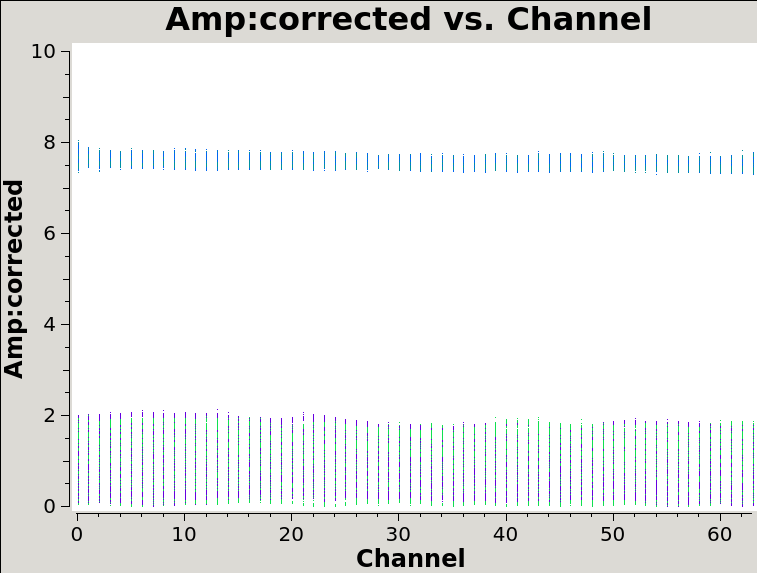

Show log 2018-03-05 11:24:58	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-03-05 11:24:58	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-03-05 11:24:58	INFO	PlotMS::load_cache	START Current memory usage: 9397.14 kilobytes.
 2018-03-05 11:24:58	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-03-05 11:24:58	INFO	PlotMS::load_cache+ Frame = 
 2018-03-05 11:24:58	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-03-05 11:24:58	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-03-05 11:24:58	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-03-05 11:24:58	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-03-05 11:24:58	INFO	PlotMS::load_cache+ formStokes = false
 2018-03-05 11:24:58	INFO	PlotMS::load_cache	Data Averaging: 
 2018-03-05 11:24:58	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-03-05 11:24:58	INFO	PlotMS::load_cache+ Time: 60 seconds. Scan: false; Field: false
 2018-03-05 11:24:58	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-03-05 11:24:58	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-03-05 11:24:58	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-03-05 11:24:58	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17):corrected vs. Channel(5)...
 2018-03-05 11:24:58	INFO	PlotMS::load_cache	Loading page header cache
 2018-03-05 11:25:01	INFO	PlotMS::load_cache	Data selection will yield a total of 1331200 plottable points (flagged and unflagged).
 2018-03-05 11:25:01	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.00806259 GB of memory (6.05663 bytes/point).
 2018-03-05 11:25:01	INFO	PlotMS::load_cache+	This is 0.0493721% of the memory avail. to CASA (16.3303 GB).
 2018-03-05 11:25:02	INFO	PlotMS::load_cache	Loading chunks......
 2018-03-05 11:25:03	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-03-05 11:25:03	INFO	PlotMS::load_cache	refTime = 2010/04/24/00:00:00.0
 2018-03-05 11:25:03	INFO	PlotMS::load_cache	Finished loading.
 2018-03-05 11:25:03	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-03-05 11:25:03	INFO	PlotMS::load_cache	Global ranges:
 2018-03-05 11:25:03	INFO	PlotMS::load_cache+	Channel: 0 to 63 (unflagged); ; 0 to 63 (flagged).
 2018-03-05 11:25:03	INFO	PlotMS::load_cache+	Amp:corrected: 0.00389149 to 8.05726 (unflagged); 1.26419e-06 to 7.98028(flagged).
 2018-03-05 11:25:03	INFO	PlotMS::plot	Plotting 971520 unflagged points.
 2018-03-05 11:24:58	INFO	PlotMS::load_cache	END Time: +5 seconds. Memory: +8178.48 kilobytes.
 2018-03-05 11:25:03	INFO	plotms::::	Plot file /home/keimpema/data2/casa/plotms_3c391-fld0-corrected-amp.png
 2018-03-05 11:25:06	INFO	plotms::::	Exporting the plot.
 2018-03-05 11:25:06	INFO	plotms::::	Calling pm.save
 2018-03-05 11:25:06	INFO	QPExporter::export	START Current memory usage: 17628.9 kilobytes.
 2018-03-05 11:25:06	INFO	QPExporter::export	END Time: +3 seconds. Memory: -43.4219 kilobytes.
 2018-03-05 11:25:10	INFO	PlotMS::plot	Exported /home/keimpema/data2/casa/plotms_3c391-fld0-corrected-amp.png

In [32]:
plotms(vis='3c391_ctm_mosaic_10s_spw0.ms', field='0', correlation='',
       timerange='08:02:00~08:17:00', antenna='', avgtime='60',
       xaxis='channel', yaxis='amp', ydatacolumn='corrected',
       coloraxis='corr', plotfile='plotms_3c391-fld0-corrected-amp.png');

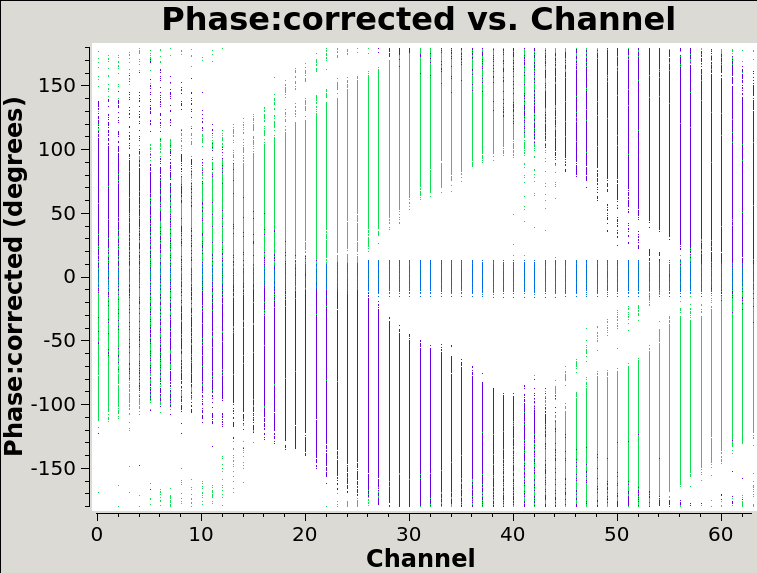

Show log 2018-03-05 11:25:13	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-03-05 11:25:13	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-03-05 11:25:13	INFO	PlotMS::load_cache	START Current memory usage: 9478.28 kilobytes.
 2018-03-05 11:25:13	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-03-05 11:25:13	INFO	PlotMS::load_cache+ Frame = 
 2018-03-05 11:25:13	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-03-05 11:25:13	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-03-05 11:25:13	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-03-05 11:25:13	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-03-05 11:25:13	INFO	PlotMS::load_cache+ formStokes = false
 2018-03-05 11:25:13	INFO	PlotMS::load_cache	Data Averaging: 
 2018-03-05 11:25:13	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-03-05 11:25:13	INFO	PlotMS::load_cache+ Time: 60 seconds. Scan: false; Field: false
 2018-03-05 11:25:13	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-03-05 11:25:13	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-03-05 11:25:13	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-03-05 11:25:13	INFO	PlotMS::load_cache	Caching for the new plot: Phase(18):corrected vs. Channel(5)...
 2018-03-05 11:25:13	INFO	PlotMS::load_cache	Loading page header cache
 2018-03-05 11:25:16	INFO	PlotMS::load_cache	Data selection will yield a total of 1331200 plottable points (flagged and unflagged).
 2018-03-05 11:25:16	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.00806259 GB of memory (6.05663 bytes/point).
 2018-03-05 11:25:16	INFO	PlotMS::load_cache+	This is 0.0493721% of the memory avail. to CASA (16.3303 GB).
 2018-03-05 11:25:16	INFO	PlotMS::load_cache	Loading chunks......
 2018-03-05 11:25:17	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-03-05 11:25:17	INFO	PlotMS::load_cache	refTime = 2010/04/24/00:00:00.0
 2018-03-05 11:25:17	INFO	PlotMS::load_cache	Finished loading.
 2018-03-05 11:25:17	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-03-05 11:25:17	INFO	PlotMS::load_cache	Global ranges:
 2018-03-05 11:25:17	INFO	PlotMS::load_cache+	Channel: 0 to 63 (unflagged); ; 0 to 63 (flagged).
 2018-03-05 11:25:17	INFO	PlotMS::load_cache+	Phase:corrected: -180 to 179.999 (unflagged); -179.999 to 180(flagged).
 2018-03-05 11:25:17	INFO	PlotMS::plot	Plotting 971520 unflagged points.
 2018-03-05 11:25:13	INFO	PlotMS::load_cache	END Time: +3 seconds. Memory: +8162.06 kilobytes.
 2018-03-05 11:25:17	INFO	plotms::::	Plot file /home/keimpema/data2/casa/plotms_3c391-fld0-corrected-phase.png
 2018-03-05 11:25:20	INFO	plotms::::	Exporting the plot.
 2018-03-05 11:25:20	INFO	plotms::::	Calling pm.save
 2018-03-05 11:25:20	INFO	QPExporter::export	START Current memory usage: 17667.1 kilobytes.
 2018-03-05 11:25:20	INFO	QPExporter::export	END Time: +3 seconds. Memory: -41.0625 kilobytes.
 2018-03-05 11:25:24	INFO	PlotMS::plot	Exported /home/keimpema/data2/casa/plotms_3c391-fld0-corrected-phase.png

In [33]:
plotms(vis='3c391_ctm_mosaic_10s_spw0.ms', field='0', correlation='',
       timerange='08:02:00~08:17:00', antenna='', avgtime='60',
       xaxis='channel', yaxis='phase', ydatacolumn='corrected',
       plotrange=[-1, -1, -180, 180], coloraxis='corr',
       plotfile='plotms_3c391-fld0-corrected-phase.png');

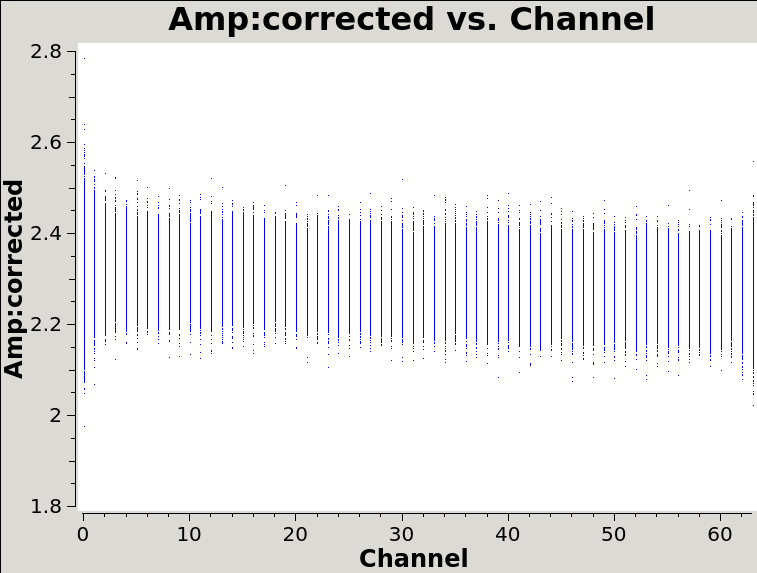

Show log 2018-03-05 11:25:27	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-03-05 11:25:27	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-03-05 11:25:27	INFO	PlotMS::load_cache	START Current memory usage: 9516.69 kilobytes.
 2018-03-05 11:25:27	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-03-05 11:25:27	INFO	PlotMS::load_cache+ Frame = 
 2018-03-05 11:25:27	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-03-05 11:25:27	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-03-05 11:25:27	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-03-05 11:25:27	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-03-05 11:25:27	INFO	PlotMS::load_cache+ formStokes = false
 2018-03-05 11:25:27	INFO	PlotMS::load_cache	Data Averaging: 
 2018-03-05 11:25:27	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-03-05 11:25:27	INFO	PlotMS::load_cache+ Time: 60 seconds. Scan: false; Field: false
 2018-03-05 11:25:27	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-03-05 11:25:27	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-03-05 11:25:27	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-03-05 11:25:27	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17):corrected vs. Channel(5)...
 2018-03-05 11:25:27	INFO	PlotMS::load_cache	Loading page header cache
 2018-03-05 11:25:30	INFO	PlotMS::load_cache	Data selection will yield a total of 1142656 plottable points (flagged and unflagged).
 2018-03-05 11:25:30	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.00698879 GB of memory (6.11627 bytes/point).
 2018-03-05 11:25:30	INFO	PlotMS::load_cache+	This is 0.0427966% of the memory avail. to CASA (16.3303 GB).
 2018-03-05 11:25:30	INFO	PlotMS::load_cache	Loading chunks......
 2018-03-05 11:25:31	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-03-05 11:25:31	INFO	PlotMS::load_cache	refTime = 2010/04/24/00:00:00.0
 2018-03-05 11:25:31	INFO	PlotMS::load_cache	Finished loading.
 2018-03-05 11:25:31	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-03-05 11:25:31	INFO	PlotMS::load_cache	Global ranges:
 2018-03-05 11:25:31	INFO	PlotMS::load_cache+	Channel: 0 to 63 (unflagged); ; 0 to 63 (flagged).
 2018-03-05 11:25:31	INFO	PlotMS::load_cache+	Amp:corrected: 1.97777 to 2.78596 (unflagged); 1.35768e-06 to 0.410715(flagged).
 2018-03-05 11:25:31	INFO	PlotMS::plot	Plotting 878976 unflagged points.
 2018-03-05 11:25:27	INFO	PlotMS::load_cache	END Time: +4 seconds. Memory: +7270.95 kilobytes.
 2018-03-05 11:25:31	INFO	plotms::::	Plot file /home/keimpema/data2/casa/plotms_3c391-fld1-corrected-amp.png
 2018-03-05 11:25:33	INFO	plotms::::	Exporting the plot.
 2018-03-05 11:25:33	INFO	plotms::::	Calling pm.save
 2018-03-05 11:25:33	INFO	QPExporter::export	START Current memory usage: 16787.7 kilobytes.
 2018-03-05 11:25:33	INFO	QPExporter::export	END Time: +1 seconds. Memory: -43.5625 kilobytes.
 2018-03-05 11:25:34	INFO	PlotMS::plot	Exported /home/keimpema/data2/casa/plotms_3c391-fld1-corrected-amp.png

In [34]:
plotms(vis='3c391_ctm_mosaic_10s_spw0.ms', field='1', correlation='RR,LL',
       timerange='', antenna='', avgtime='60',
       xaxis='channel', yaxis='amp', ydatacolumn='corrected',
       plotfile='plotms_3c391-fld1-corrected-amp.png');

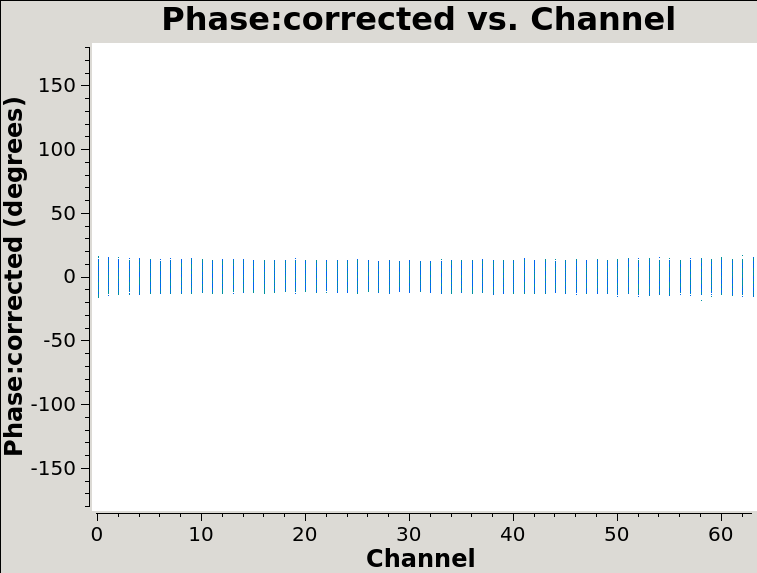

Show log 2018-03-05 11:25:35	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-03-05 11:25:35	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-03-05 11:25:35	INFO	PlotMS::load_cache	START Current memory usage: 9510.64 kilobytes.
 2018-03-05 11:25:35	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-03-05 11:25:35	INFO	PlotMS::load_cache+ Frame = 
 2018-03-05 11:25:35	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-03-05 11:25:35	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-03-05 11:25:35	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-03-05 11:25:35	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-03-05 11:25:35	INFO	PlotMS::load_cache+ formStokes = false
 2018-03-05 11:25:35	INFO	PlotMS::load_cache	Data Averaging: 
 2018-03-05 11:25:35	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-03-05 11:25:35	INFO	PlotMS::load_cache+ Time: 60 seconds. Scan: false; Field: false
 2018-03-05 11:25:35	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-03-05 11:25:35	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-03-05 11:25:35	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-03-05 11:25:35	INFO	PlotMS::load_cache	Caching for the new plot: Phase(18):corrected vs. Channel(5)...
 2018-03-05 11:25:35	INFO	PlotMS::load_cache	Loading page header cache
 2018-03-05 11:25:38	INFO	PlotMS::load_cache	Data selection will yield a total of 1142656 plottable points (flagged and unflagged).
 2018-03-05 11:25:38	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.00698879 GB of memory (6.11627 bytes/point).
 2018-03-05 11:25:38	INFO	PlotMS::load_cache+	This is 0.0427966% of the memory avail. to CASA (16.3303 GB).
 2018-03-05 11:25:38	INFO	PlotMS::load_cache	Loading chunks......
 2018-03-05 11:25:39	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-03-05 11:25:39	INFO	PlotMS::load_cache	refTime = 2010/04/24/00:00:00.0
 2018-03-05 11:25:39	INFO	PlotMS::load_cache	Finished loading.
 2018-03-05 11:25:39	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-03-05 11:25:39	INFO	PlotMS::load_cache	Global ranges:
 2018-03-05 11:25:39	INFO	PlotMS::load_cache+	Channel: 0 to 63 (unflagged); ; 0 to 63 (flagged).
 2018-03-05 11:25:39	INFO	PlotMS::load_cache+	Phase:corrected: -17.6729 to 17.4073 (unflagged); -179.998 to 180(flagged).
 2018-03-05 11:25:39	INFO	PlotMS::plot	Plotting 878976 unflagged points.
 2018-03-05 11:25:35	INFO	PlotMS::load_cache	END Time: +3 seconds. Memory: +7271.31 kilobytes.
 2018-03-05 11:25:39	INFO	plotms::::	Plot file /home/keimpema/data2/casa/plotms_3c391-fld1-corrected-phase.png
 2018-03-05 11:25:42	INFO	plotms::::	Exporting the plot.
 2018-03-05 11:25:42	INFO	plotms::::	Calling pm.save
 2018-03-05 11:25:42	INFO	QPExporter::export	START Current memory usage: 16799.1 kilobytes.
 2018-03-05 11:25:42	INFO	QPExporter::export	END Time: +4 seconds. Memory: -40.5625 kilobytes.
 2018-03-05 11:25:45	INFO	PlotMS::plot	Exported /home/keimpema/data2/casa/plotms_3c391-fld1-corrected-phase.png

In [35]:
plotms(vis='3c391_ctm_mosaic_10s_spw0.ms', field='1', correlation='RR,LL',
       timerange='', antenna='', avgtime='60',
       xaxis='channel', yaxis='phase', ydatacolumn='corrected',
       plotrange=[-1, -1, -180, 180], coloraxis='corr',
       plotfile='plotms_3c391-fld1-corrected-phase.png');

Another nice display is to use **`plotms`** to plot the amplitude and phase of the `CORRECTED_DATA` column against one another for one of the parallel-hand correlations (RR or LL); the signal in the cross-hands, (RL and LR) is much smaller and will be noise-like for an unpolarized calibrator. This should then show a nice oval of visibilities, with some scatter, centered at zero phase and at the amplitude found for that source in fluxscale.

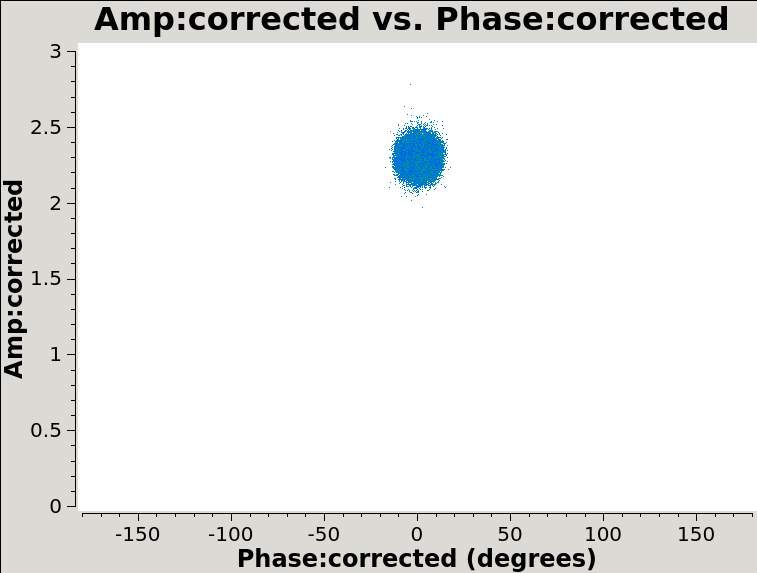

Show log 2018-03-05 11:25:48	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-03-05 11:25:48	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-03-05 11:25:48	INFO	PlotMS::load_cache	START Current memory usage: 9539.34 kilobytes.
 2018-03-05 11:25:48	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-03-05 11:25:48	INFO	PlotMS::load_cache+ Frame = 
 2018-03-05 11:25:48	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-03-05 11:25:48	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-03-05 11:25:48	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-03-05 11:25:48	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-03-05 11:25:48	INFO	PlotMS::load_cache+ formStokes = false
 2018-03-05 11:25:48	INFO	PlotMS::load_cache	Data Averaging: 
 2018-03-05 11:25:48	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-03-05 11:25:48	INFO	PlotMS::load_cache+ Time: 60 seconds. Scan: false; Field: false
 2018-03-05 11:25:48	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-03-05 11:25:48	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-03-05 11:25:48	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-03-05 11:25:48	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17):corrected vs. Phase(18):corrected...
 2018-03-05 11:25:48	INFO	PlotMS::load_cache	Loading page header cache
 2018-03-05 11:25:50	INFO	PlotMS::load_cache	Data selection will yield a total of 1142656 plottable points (flagged and unflagged).
 2018-03-05 11:25:50	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0115594 GB of memory (10.1163 bytes/point).
 2018-03-05 11:25:50	INFO	PlotMS::load_cache+	This is 0.0707853% of the memory avail. to CASA (16.3303 GB).
 2018-03-05 11:25:51	INFO	PlotMS::load_cache	Loading chunks......
 2018-03-05 11:25:51	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-03-05 11:25:51	INFO	PlotMS::load_cache	refTime = 2010/04/24/00:00:00.0
 2018-03-05 11:25:51	INFO	PlotMS::load_cache	Finished loading.
 2018-03-05 11:25:51	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-03-05 11:25:52	INFO	PlotMS::load_cache	Global ranges:
 2018-03-05 11:25:52	INFO	PlotMS::load_cache+	Phase:corrected: -17.6729 to 17.4073 (unflagged); ; -179.998 to 180 (flagged).
 2018-03-05 11:25:52	INFO	PlotMS::load_cache+	Amp:corrected: 1.97777 to 2.78596 (unflagged); 1.35768e-06 to 0.410715(flagged).
 2018-03-05 11:25:52	INFO	PlotMS::plot	Plotting 878976 unflagged points.
 2018-03-05 11:25:48	INFO	PlotMS::load_cache	END Time: +3 seconds. Memory: +11738.7 kilobytes.
 2018-03-05 11:25:52	INFO	plotms::::	Plot file /home/keimpema/data2/casa/plotms_3c391-fld1-corrected-ampvsphase.png
 2018-03-05 11:25:55	INFO	plotms::::	Exporting the plot.
 2018-03-05 11:25:55	INFO	plotms::::	Calling pm.save
 2018-03-05 11:25:55	INFO	QPExporter::export	START Current memory usage: 21305.3 kilobytes.
 2018-03-05 11:25:55	INFO	QPExporter::export	END Time: +3 seconds. Memory: -57.5156 kilobytes.
 2018-03-05 11:25:58	INFO	PlotMS::plot	Exported /home/keimpema/data2/casa/plotms_3c391-fld1-corrected-ampvsphase.png

In [36]:
plotms(vis='3c391_ctm_mosaic_10s_spw0.ms', field='1', correlation='RR,LL',
       timerange='', antenna='', avgtime='60',
       xaxis='phase', xdatacolumn='corrected', yaxis='amp', ydatacolumn='corrected',
       plotrange=[-180, 180, 0, 3], coloraxis='corr',
       plotfile='plotms_3c391-fld1-corrected-ampvsphase.png');

Inspecting the data at this stage may well show up previously-unnoticed bad data. Plotting the corrected amplitude against UV distance or against time is a good way to find such issues. If you find bad data, you can remove them via interactive flagging in **`plotms`** (*not in the notebook interface yet*) or via manual flagging in **`flagdata`** once you have identified the offending antennas/baselines/channels/times. When you are happy that all data (particularly on your target source) look good, you may proceed.

Now that the calibration has been applied to the target data we can split off the science targets, creating a new, calibrated measurement set containing all the target fields. 

In [37]:
split(vis='3c391_ctm_mosaic_10s_spw0.ms', outputvis='3c391_ctm_mosaic_spw0.ms',
      datacolumn='corrected', field='2~8');

Show log 2018-03-05 11:25:58	INFO	MSTransformManager::parseMsSpecParams	Input file name is 3c391_ctm_mosaic_10s_spw0.ms
 2018-03-05 11:25:58	INFO	MSTransformManager::parseMsSpecParams	Data column is CORRECTED
 2018-03-05 11:25:58	INFO	MSTransformManager::parseMsSpecParams	Output file name is 3c391_ctm_mosaic_spw0.ms
 2018-03-05 11:25:58	INFO	MSTransformManager::parseDataSelParams	field selection is 2~8
 2018-03-05 11:25:58	INFO	MSTransformManager::colCheckInfo	Adding DATA column to output MS from input CORRECTED_DATA column
 2018-03-05 11:25:58	INFO	MSTransformManager::initDataSelectionParams	Selected Fields Ids are [2, 3, 4, 5, 6, 7, 8]
 2018-03-05 11:25:58	INFO	MSTransformManager::open	Select data
 2018-03-05 11:25:58	INFO	MSTransformManager::createOutputMSStructure	Create output MS structure
 2018-03-05 11:25:58	INFO	MSTransformDataHandler::makeSelection	764914 out of 845379 rows are going to be considered due to the selection criteria.
 2018-03-05 11:26:47	INFO	split::::	CASA Version 5.1.1-5 
 2018-03-05 11:26:47	INFO	split::::

## Initial imaging

Now that we have split off the target data into a separate measurement set with all the calibration applied, it's time to make an image. Recall that the visibility data and the sky brightness distribution (a.k.a. image) are Fourier transform pairs.

$I(l,m) = \int V(u,v) e^{[2\pi i(ul + vm)]} dudv$

The $u$ and $v$ coordinates are the baselines measured in units of the observing wavelength, while the $l$ and $m$ coordinates are the direction cosines on the sky. For generality, the sky coordinates are written in terms of direction cosines, but for most VLA (and ALMA) observations they can be related simply to the right ascension ($l$) and declination ($m$). Also recall that this equation is valid only if the $w$ coordinate of the baselines can be neglected. This assumption is almost always true at high frequencies and smaller VLA configurations (such as the 4.6 GHz D-configuration observations here). The $w$ coordinate cannot be neglected at lower frequencies and larger configurations (e.g., 0.33 GHz, A-configuration observations). This expression also neglects other factors, such as the shape of the primary beam. For more information on imaging, see [Synthesis Imaging](http://casa.nrao.edu/docs/cookbook/casa_cookbook006.html) within the CASA Reference Manual. 

CASA has a single task **`clean`** which both Fourier transforms the data and deconvolves the resulting image. For the purposes of this tutorial, we will make a simple mosaic clean image in Stokes I only.

Setting the appropriate pixel size for imaging depends upon basic optics aspects of interferometry. Using **`plotms`** to look at the newly-calibrated, target-only data set: 

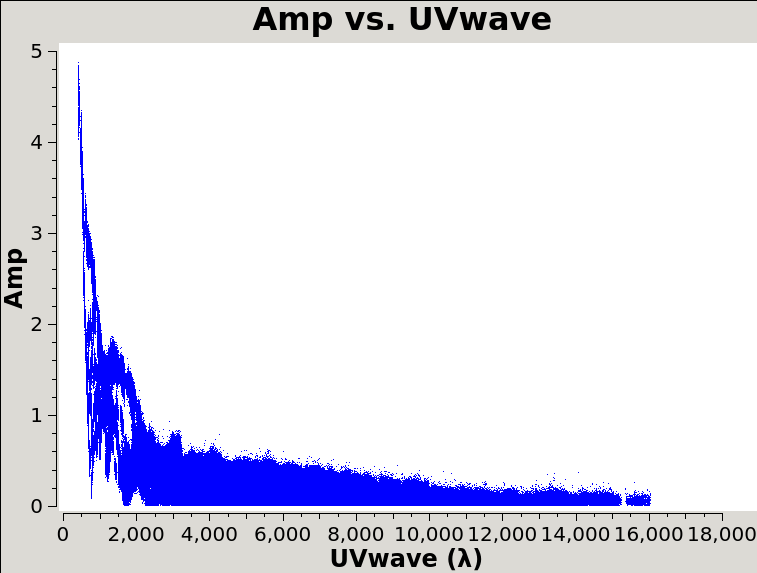

Show log 2018-03-05 12:45:48	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2018-03-05 12:45:48	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2018-03-05 12:45:48	INFO	PlotMS::load_cache	START Current memory usage: 9561.8 kilobytes.
 2018-03-05 12:45:48	INFO	PlotMS::load_cache	Plot Data Transformations:
 2018-03-05 12:45:48	INFO	PlotMS::load_cache+ Frame = 
 2018-03-05 12:45:48	INFO	PlotMS::load_cache+ VelDef = RADIO
 2018-03-05 12:45:48	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2018-03-05 12:45:48	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2018-03-05 12:45:48	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2018-03-05 12:45:48	INFO	PlotMS::load_cache+ formStokes = false
 2018-03-05 12:45:48	INFO	PlotMS::load_cache	Data Averaging: 
 2018-03-05 12:45:48	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2018-03-05 12:45:48	INFO	PlotMS::load_cache+ Time: 30 seconds. Scan: false; Field: false
 2018-03-05 12:45:48	INFO	PlotMS::load_cache	Plot Data Calibration:
 2018-03-05 12:45:48	INFO	PlotMS::load_cache+ Use Calibration = 0
 2018-03-05 12:45:48	INFO	PlotMS::load_cache+ Calibration Library = 
 2018-03-05 12:45:48	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17):data vs. UVwave(29)...
 2018-03-05 12:45:48	INFO	PlotMS::load_cache	Loading page header cache
 2018-03-05 12:45:51	INFO	PlotMS::load_cache	Data selection will yield a total of 2293440 plottable points (flagged and unflagged).
 2018-03-05 12:45:51	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0326342 GB of memory (14.2294 bytes/point).
 2018-03-05 12:45:51	INFO	PlotMS::load_cache+	This is 0.199839% of the memory avail. to CASA (16.3303 GB).
 2018-03-05 12:45:51	INFO	PlotMS::load_cache	Loading chunks......
 2018-03-05 12:45:54	INFO	PlotMS::load_cache	Generating the plot mask.
 2018-03-05 12:45:54	INFO	PlotMS::load_cache	refTime = 2010/04/24/00:00:00.0
 2018-03-05 12:45:54	INFO	PlotMS::load_cache	Finished loading.
 2018-03-05 12:45:54	INFO	PlotMS::load_cache	Setting up iteration indexing (if necessary), and calculating plot ranges.
 2018-03-05 12:45:54	INFO	PlotMS::load_cache	Global ranges:
 2018-03-05 12:45:54	INFO	PlotMS::load_cache+	UVwave: 424.009 to 16036.1 (unflagged); ; 444.095 to 15876.8 (flagged).
 2018-03-05 12:45:54	INFO	PlotMS::load_cache+	Amp:data: 5.31842e-05 to 4.8756 (unflagged); 1.52637e-06 to 5.06174(flagged).
 2018-03-05 12:45:55	INFO	PlotMS::plot	Plotting 1595328 unflagged points.
 2018-03-05 12:45:48	INFO	PlotMS::load_cache	END Time: +7 seconds. Memory: +33041.7 kilobytes.
 2018-03-05 12:45:55	INFO	plotms::::	Plot file /home/keimpema/data2/casa/plotms_3c391-mosaic0-uvwave.png
 2018-03-05 12:45:55	INFO	plotms::::	Exporting the plot.
 2018-03-05 12:45:55	INFO	plotms::::	Calling pm.save
 2018-03-05 12:45:55	INFO	QPExporter::export	START Current memory usage: 42649.3 kilobytes.
 2018-03-05 12:45:55	INFO	QPExporter::export	END Time: +0 seconds. Memory: -36.5 kilobytes.
 2018-03-05 12:45:56	INFO	PlotMS::plot	Exported /home/keimpema/data2/casa/plotms_3c391-mosaic0-uvwave.png

In [39]:
plotms(vis='3c391_ctm_mosaic_spw0.ms', xaxis='uvwave', yaxis='amp',
       ydatacolumn='data', field='0', avgtime='30', correlation='RR',
       plotfile='plotms_3c391-mosaic0-uvwave.png', overwrite=True);

The maximum baseline is about 16,000 wavelengths, i.e., an angular scale of 12 arcseconds ($\lambda/D=1/16000$). The most effective cleaning occurs with 3-5 pixels across the synthesized beam. For example, a cell size of 2.5 arcseconds will give just under 5 pixels per beam.

The supernova remnant itself is known to have a diameter of order 9 arcminutes, corresponding to about 216 pixels for the chosen cell size. The mosaic was set up with 7 fields, 1 centered on the remnant with 6 flanking fields; the spacing of the fields was chosen based on the size of the antenna primary beam. For the choice of `ftmachine='mosaic'` (our main mosaicking algorithm), you do not have to fit the mosaic inside the inner quarter of the total image in order to prevent image artifacts arising from aliasing, we just want to have a bit of padding around the outside. Although CASA has the feature that its Fourier transform engine (FFTW) does not require a strict power of 2 for the number of linear pixels in a given image axis, it is somewhat more efficient if the number of pixels on a side is a composite number divisible by any pair of 2 and 3 and/or 5. Because `clean` internally applies a padding of 1.2 (=3x2/5) choose 480, which is 25 × 3 × 5 (so 480 × 1.2 = 576 = 26 × 32). We therefore set `imsize=[480,480]` and our mosaic fits comfortably inside the image. 

Running `clean` will take about two minutes.

In [40]:
clearstat()
clean(vis='3c391_ctm_mosaic_spw0.ms',
      imagename='3c391_ctm_spw0v2_I',
      field='', spw='',
      mode='mfs',
      niter=5000,
      gain=0.1, threshold='1.0mJy',
      psfmode='clark',
      imagermode='mosaic', ftmachine='mosaic',
      multiscale=[0],
      interactive=False,
      imsize=[480, 480], cell=['2.5arcsec', '2.5arcsec'],
      stokes='I',
      weighting='briggs', robust=0.5,
      usescratch=False)

Show log 2018-03-05 12:46:12	INFO	clean::::	nchan=-1 start=0 width=1
 2018-03-05 12:46:12	INFO	clean::::	Use default channelization for clean
 2018-03-05 12:46:12	INFO	clean::::	clean image: 3c391_ctm_spw0v2_I
 2018-03-05 12:46:12	INFO	clean::::	FTMachine used is mosaic 
 2018-03-05 12:46:12	INFO	Imager::setvp() Setting voltage pattern parameters
 2018-03-05 12:46:12	INFO	Imager::setvp() Sky position tolerance is 180 degrees
 2018-03-05 12:46:12	INFO	Imager::setvp() Using system default voltage patterns for each telescope
 2018-03-05 12:46:12	INFO	imager::setDataOnThisMS()	Performing selection on MeasurementSet : /home/keimpema/data2/casa/3c391_ctm_mosaic_spw0.ms
 2018-03-05 12:46:12	INFO	imager::setDataOnThisMS()	Selecting on fields : 0,1,2,3,4,5,6
 2018-03-05 12:46:12	INFO	imager::setDataOnThisMS()	Selecting on spectral windows expression :*
 2018-03-05 12:46:12	INFO	imager::setDataOnThisMS()	Selected all 764914 rows
 2018-03-05 12:46:12	INFO	imager::setDataOnThisMS()	Selected : [64 chans in spw 0]
 2018-03-05 12:46:12	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on 3c391_ctm_mosaic_spw0.ms...
 2018-03-05 12:46:13	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on 3c391_ctm_mosaic_spw0.ms...
 2018-03-05 12:46:13	INFO	imager::defineimage()	Defining image properties:nx=480 ny=480 cellx='2.5arcsec' celly='2.5arcsec' stokes=I' mode=MFS nchan=-1 start=0 step=1 spwids=[-1] fieldid=-1 facets=1 frame=5 distance='0'
 2018-03-05 12:46:13	INFO	imager::defineimage() phaseCenter='18:49:24.24, 359.04.19.42, ' mStart='Radialvelocity: 0' qStep='0 '' mFreqStart='Frequency: 0
 2018-03-05 12:46:14	INFO	imager::weight()	Weighting MS: Imaging weights will be changed
 2018-03-05 12:46:14	INFO	imager::weight()	Briggs weighting: sidelobes will be suppressed over full image
 2018-03-05 12:46:15	INFO	VisSetUtil::VisImagingWeight() Normal robustness, robust = 0.5
 2018-03-05 12:46:15	INFO	clean::::	Used mask(s) : [''] to create mask image(s) : 3c391_ctm_spw0v2_I.mask
 2018-03-05 12:46:15	INFO	imager::setoptions() Setting processing options
 2018-03-05 12:46:15	INFO	clean::::	No model found. Making empty initial model : 3c391_ctm_spw0v2_I.model
 2018-03-05 12:46:16	INFO	Imager::imagecoordinates() Center frequency = 4.59835 GHz, synthesized continuum bandwidth = 0.127992 GHz
 2018-03-05 12:46:16	INFO	imager::clean()	Using multifield Clark clean
 2018-03-05 12:46:16	INFO	imager::createFTMachine() Multiple fields or facets: transforms will be padded by a factor 1.2
 2018-03-05 12:46:16	INFO	imager::createFTMachine() Performing mosaic gridding
 2018-03-05 12:46:16	INFO	Imager::setmosaicftmachine Using antenna primary beams for determining beams for gridding
 2018-03-05 12:46:16	INFO	imager::clean()	Clean gain = 0.1, Niter = 5000, Threshold = 1 mJy
 2018-03-05 12:46:16	INFO	imager::clean()	Starting deconvolution
 2018-03-05 12:47:08	INFO	CubeSkyEquation::makeSimplePSF	Maximum of approximate PSF for field 0 = 1.15288 : renormalizing to unity
 2018-03-05 12:47:08	INFO	ImageSkyModel::makeApproxPSFs	bmaj: 17.057", bmin: 14.585", bpa: 26.2787 deg
 2018-03-05 12:47:08	INFO	MFCleanImageSkyModel::solve	*** Starting major cycle 0
 2018-03-05 12:47:31	INFO	MFCleanImageSkyModel::solve	The minor-cycle threshold is MAX[ 0.95 x 0.001 , peak residual x 0.157496 ] 
 2018-03-05 12:47:31	INFO	MFCleanImageSkyModel::solve	Maximum residual = 0.123721, cleaning down to 0.0194855
 2018-03-05 12:47:31	INFO	MFCleanImageSkyModel::solve	Processing model 0
 2018-03-05 12:47:31	INFO	ClarkCleanModel::singleSolve	Initial maximum residual: 0.129957
 2018-03-05 12:47:31	INFO	MFCleanImageSkyModel::solve	Finished Clark clean inner cycle 
 2018-03-05 12:47:31	INFO	MFCleanImageSkyModel::solve	Clean used 573 iterations to approach a threshhold of 0.0194855
 2018-03-05 12:47:31	INFO	MFCleanImageSkyModel::solve	1.37599 Jy <- cleaned in this cycle for model 0 (Total flux : 1.37599Jy)
 2018-03-05 12:47:31	INFO	MFCleanImageSkyModel::solve	*** Starting maj

Interactive cleaning is not (yet) supported in this notebook interface. We can open the **`viewer`** to see the result of the imaging.

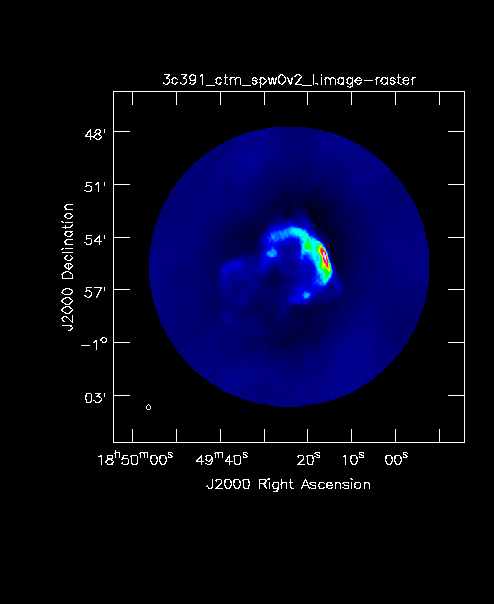

In [41]:
viewer('3c391_ctm_spw0v2_I.image')

Note that the image is cut off in a circular fashion at the edges, corresponding to the default minimum primary beam response (minpb) within clean of 0.2. 